In [1]:
import numpy as np
from typing import Any, List, Dict
import yaml
import os
new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)
import src.gmm.bgmm as bgmm 
import src.utils as utils
from src.sampler.getbatch import SyntheticDataBatcher
from src.utils import load_pp_list
import pickle
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.set_printoptions(precision=4)

class ModifiedGaussianSampler:
    def __init__(self, b: float = 0.5, components: int = 3, features: int = 3) -> None:
        self.model: Any = None
        self.b: float = b
        self.Z: Any = None
        self.q: Any = None
        self.components: int = components
        self.features: int = features

    def load_p(self, filename: str) -> None:
        print('loading model: ', filename)
        with open(filename, 'rb') as file:
            params = pickle.load(file)
            self.model = params['model']
            print(self.model)
            print(self.model.weights_)

    def p(self, x: np.ndarray) -> np.float64:
        return np.exp(self.model.score_samples(x.reshape(1, -1)))

    def randomly_select_component(self) -> int:
        """Randomly select a component based on weights and return its index."""
        weights = self.model.weights_
        selected_component_index = np.random.choice(np.arange(len(weights)), p=weights)
        return selected_component_index
    
    def autocorrelation(self, samples, lag=1):
        """Compute the autocorrelation of the samples."""
        n = len(samples)
        mean = np.mean(samples, axis=0)
        var = np.var(samples, axis=0)
        autocorr = np.sum((samples[:-lag] - mean) * (samples[lag:] - mean), axis=0) / (var * (n - lag))
        return autocorr

    def check_convergence(self, samples, max_lag=10):
        """Check the convergence of the algorithm by assessing the autocorrelation of the samples."""
        for lag in range(1, max_lag + 1):
            autocorr = self.autocorrelation(samples, lag)
            print(f"Autocorrelation at lag {lag}: {autocorr}")
            if np.all(np.abs(autocorr) < 0.05):
                print("Convergence likely achieved.")
                return True
        print("Convergence not yet achieved.")
        return False

    
    def two_step_sample(self, n_samples: int = 5, first_sample: int = 1000) -> np.ndarray:
        # Sample from the GMM
        samples, _ = self.model.sample(n_samples = first_sample)

        # Calculate the probabilities of the samples
        log_probs = self.model.score_samples(samples)
        probs = np.exp(log_probs)
        
        # Modify the probabilities according to p^b
        modified_probs = probs ** self.b
        modified_probs /= np.sum(modified_probs)  # normalize to create a probability distribution

        # Resample a subsample according to the new density
        n_resamples = n_samples  # number of samples to resample
        resample_indices = np.random.choice(range(len(samples)), size=n_resamples, p=modified_probs)
        resampled_samples = samples[resample_indices]
        print("\nResampled Samples:")
        print(resampled_samples)

        return np.array(resampled_samples)

    
    def plot_mixture_of_bivariate_gaussians(self, ax, i, j, PP):
        # Means and Covariances
        means = self.model.means_
        covariances = self.model.covariances_
        x, y = np.mgrid[means[:, i].min()-3:means[:, i].max()+3:.01,
                        means[:, j].min()-3:means[:, j].max()+3:.01]
        pos = np.dstack((x, y))
        pdf = np.zeros(pos.shape[:2])

        # Summing the probability densities of each Gaussian
        for k in range(means.shape[0]):
            mean_ij = means[k, [i, j]]
            covariance_ij = covariances[k, [i, j], :][:, [i, j]]
            rv = multivariate_normal(mean_ij, covariance_ij)
            pdf += rv.pdf(pos)

        ax.contourf(x, y, pdf, cmap='viridis')
        ax.set_xlabel(PP[i], fontsize=18)
        ax.set_ylabel(PP[j], fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size

    def plot_samples_densities(self, PP, new_data_points, star_class):
        fig, axs = plt.subplots(len(PP), len(PP), figsize=(15, 15))
        for i in range(len(PP)):
            for j in range(len(PP)):
                if i < j:
                    self.plot_mixture_of_bivariate_gaussians(axs[i, j], i, j, PP)
                    axs[i, j].scatter(new_data_points[:, i], new_data_points[:, j], color='red')
                else:
                    axs[i, j].axis('off')
                axs[i, j].yaxis.set_label_coords(-0.3, 0.5)  # Adjust the x-coordinate for y-axis labels

        plt.tight_layout()
        plt.savefig(star_class +str(self.b)+ '_density.png')
        plt.show()
    
    def plot_samples_densities_full(self, PP, new_data_points, new_data_points2, star_class):
        fig, axs = plt.subplots(len(PP), len(PP), figsize=(15, 15))
        for i in range(len(PP)):
            for j in range(len(PP)):
                if i < j:
                    self.plot_mixture_of_bivariate_gaussians(axs[i, j], i, j, PP)
                    axs[i, j].scatter(new_data_points[:, i], new_data_points[:, j], color='red')
                elif j < i:
                    self.plot_mixture_of_bivariate_gaussians(axs[i, j], j, i, PP)
                    axs[i, j].scatter(new_data_points2[:, j], new_data_points2[:, i], color='red')
                else: 
                    axs[i, j].axis('off')
                axs[i, j].yaxis.set_label_coords(-0.3, 0.5)  # Adjust the x-coordinate for y-axis labels

        plt.tight_layout()
        plt.savefig(star_class + '_density.png')
        plt.show()

    def modify_and_sample(self, path: str, n_samples=5, mode='two_steps') -> np.ndarray:
        np.set_printoptions(suppress=True)

        print(n_samples)
        self.load_p(path)
        print('Model loaded: ', self.model)
        print(self.model.means_)
        print('mode: ', mode)
        if mode == 'two_steps': 
            samples = self.two_step_sample(n_samples=n_samples)
        else: 
            raise('The mode ' + mode + 'is not implemented.')
        return samples


In [2]:
with open('src/configuration/nn_config.yaml', 'r') as file:
    nn_config = yaml.safe_load(file)

ITERATIONS_MH: int = nn_config['sampling']['iterations']
BURNIN_MH: int = nn_config['sampling']['burnin']
print(ITERATIONS_MH)
print(BURNIN_MH)
    
with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE: Dict[str, Any] = yaml.safe_load(file)

PATHS: Dict[str, str] = YAML_FILE['paths']
PATH_MODELS: str = PATHS['PATH_MODELS']

with open('src/configuration/regressor.yaml', 'r') as file:
    config_file = yaml.safe_load(file)
vae_model: str =   config_file['model_parameters']['ID'] 

PP = utils.load_pp_list(vae_model)

n_samples = 16 

print('Using vae model: '+ vae_model)

sufix_path: str =   config_file['model_parameters']['sufix_path']

print('sufix path: '+ sufix_path)

synthetic_samples_by_class = 64

seq_length = 300

100000
10000
FEATURES:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
Using vae model: gn42liaz
sufix path: GAIA3_LOG_IMPUTED_BY_CLASS_6PP


In [3]:
#PP = ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']

PP =  [r'$\log P$', r'$\log T_{\rm eff}$', '[Fe/H]',  '$M_G$', r'$\log R$', r'$\log g$']

In [4]:
sampler = ModifiedGaussianSampler(b=1, components=3, features=PP)
sampler

In [5]:
prior = True
bgmm.fit_gaussians(prior, columns= ['Type','Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg'])


ACEP
{'CompleteName': 'Anomalous Cepheids', 'max_period': 2.5, 'min_period': 0.3, 'Binary': {'Period': [1, 10], 'teff_val': [5000, 6000], 'FeH_J95': [-0.1, 0.1], 'abs_Gmag': [0.5, 2.0], 'radius_val': [0.8, 1.5], 'logg': [3.5, 4.5], 'Midpoints': {'Period': 5.5, 'teff_val': 5500, 'FeH_J95': 0.0, 'abs_Gmag': 1.25, 'radius_val': 1.15, 'logg': 4}}, 'Ternary': {'Period': [5, 20], 'teff_val': [4500, 5600], 'FeH_J95': [-0.2, 0.2], 'abs_Gmag': [0.7, 2.5], 'radius_val': [1, 2], 'logg': [3, 4], 'Midpoints': {'Period': 12.5, 'teff_val': 5050, 'FeH_J95': 0.0, 'abs_Gmag': 1.6, 'radius_val': 1.5, 'logg': 3.5}}, 'Pulsating': {'Period': [0.5, 8], 'teff_val': [5200, 5800], 'FeH_J95': [-0.1, 0.1], 'abs_Gmag': [0.6, 1.8], 'radius_val': [0.9, 1.4], 'logg': [3.8, 4.2], 'Midpoints': {'Period': 4.25, 'teff_val': 5500, 'FeH_J95': 0.0, 'abs_Gmag': 1.2, 'radius_val': 1.15, 'logg': 4}}}
[[1.7047 8.6125 0.     1.25   0.1398 4.    ]
 [2.5257 8.5271 0.     1.6    0.4055 3.5   ]
 [1.4469 8.6125 0.     1.2    0.1398 4

##################################################
star_class:  RRLYR
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_RRLYR_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_RRLYR_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-0.6183,  8.7947, -0.3   ,  0.6833, -0.2892,  3.    ]),
                        n_components=3, random_state=42)
[0.2773 0.5339 0.1889]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-0.6183,  8.7947, -0.3   ,  0.6833, -0.2892,  3.    ]),
                        n_components=3, random_state=42)
[[-0.7362  3.6227 -1.7233  7.4219 -0.4462  4.4166]
 [-0.7825  3.7335 -2.9479  5.8686 -0.3641  4.5768]
 [-0.7836  3.8451 -1.3124  2.4865  0.7175  3.8863]]
mode:  two_steps

Resampl

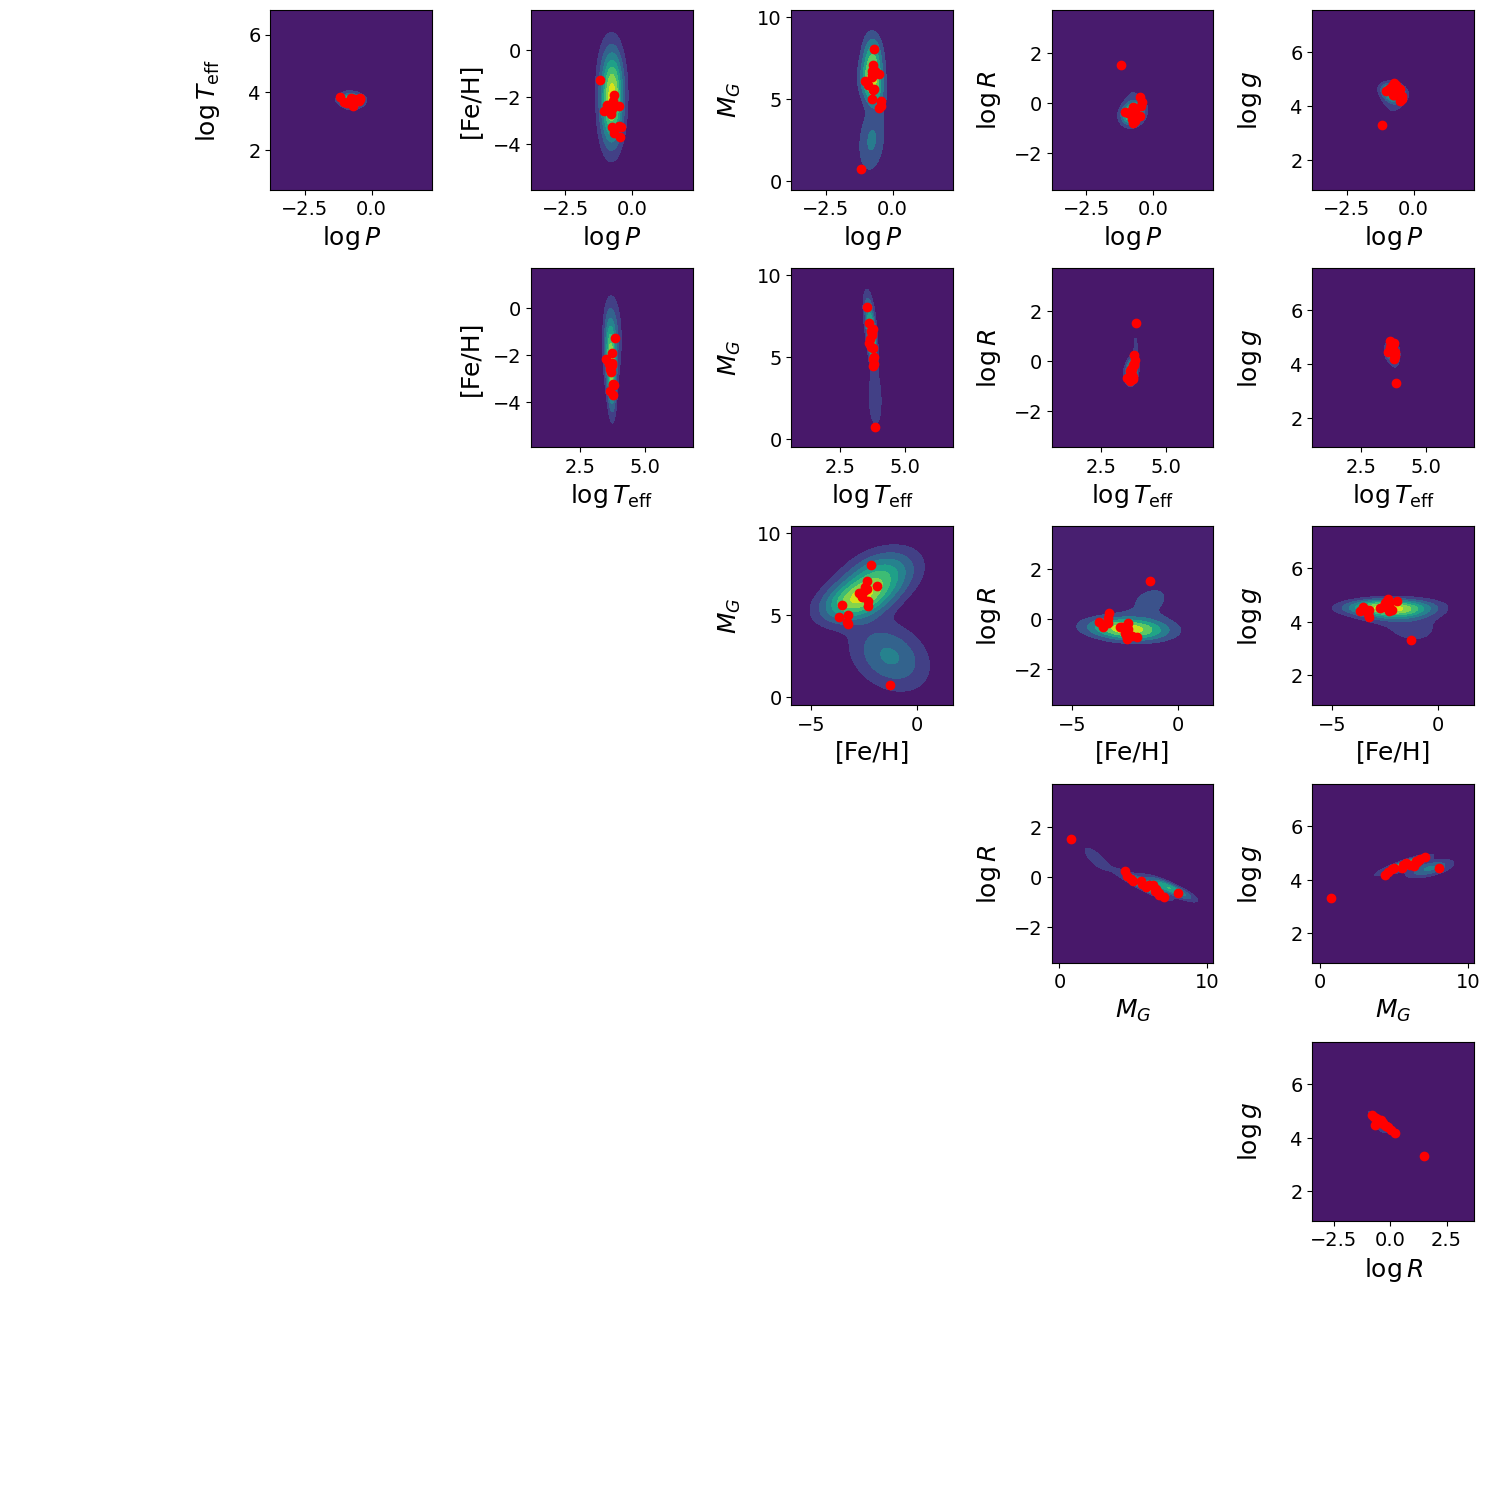

##################################################
star_class:  CEP
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_CEP_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_CEP_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([2.9114, 8.7853, 0.    , 0.    , 3.6217, 1.275 ]),
                        n_components=4, random_state=42)
[0.5303 0.146  0.0261 0.2976]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([2.9114, 8.7853, 0.    , 0.    , 3.6217, 1.275 ]),
                        n_components=4, random_state=42)
[[ 1.094   3.7909 -0.7561  2.6847  0.7982  3.7914]
 [ 0.4873  3.771  -3.7535  5.0978 -0.1712  4.4524]
 [ 1.6934  3.8754 -0.7959  0.409   1.7181  3.2054]
 [ 0.5986  3.7656 -1.6281  4.9092 -0.

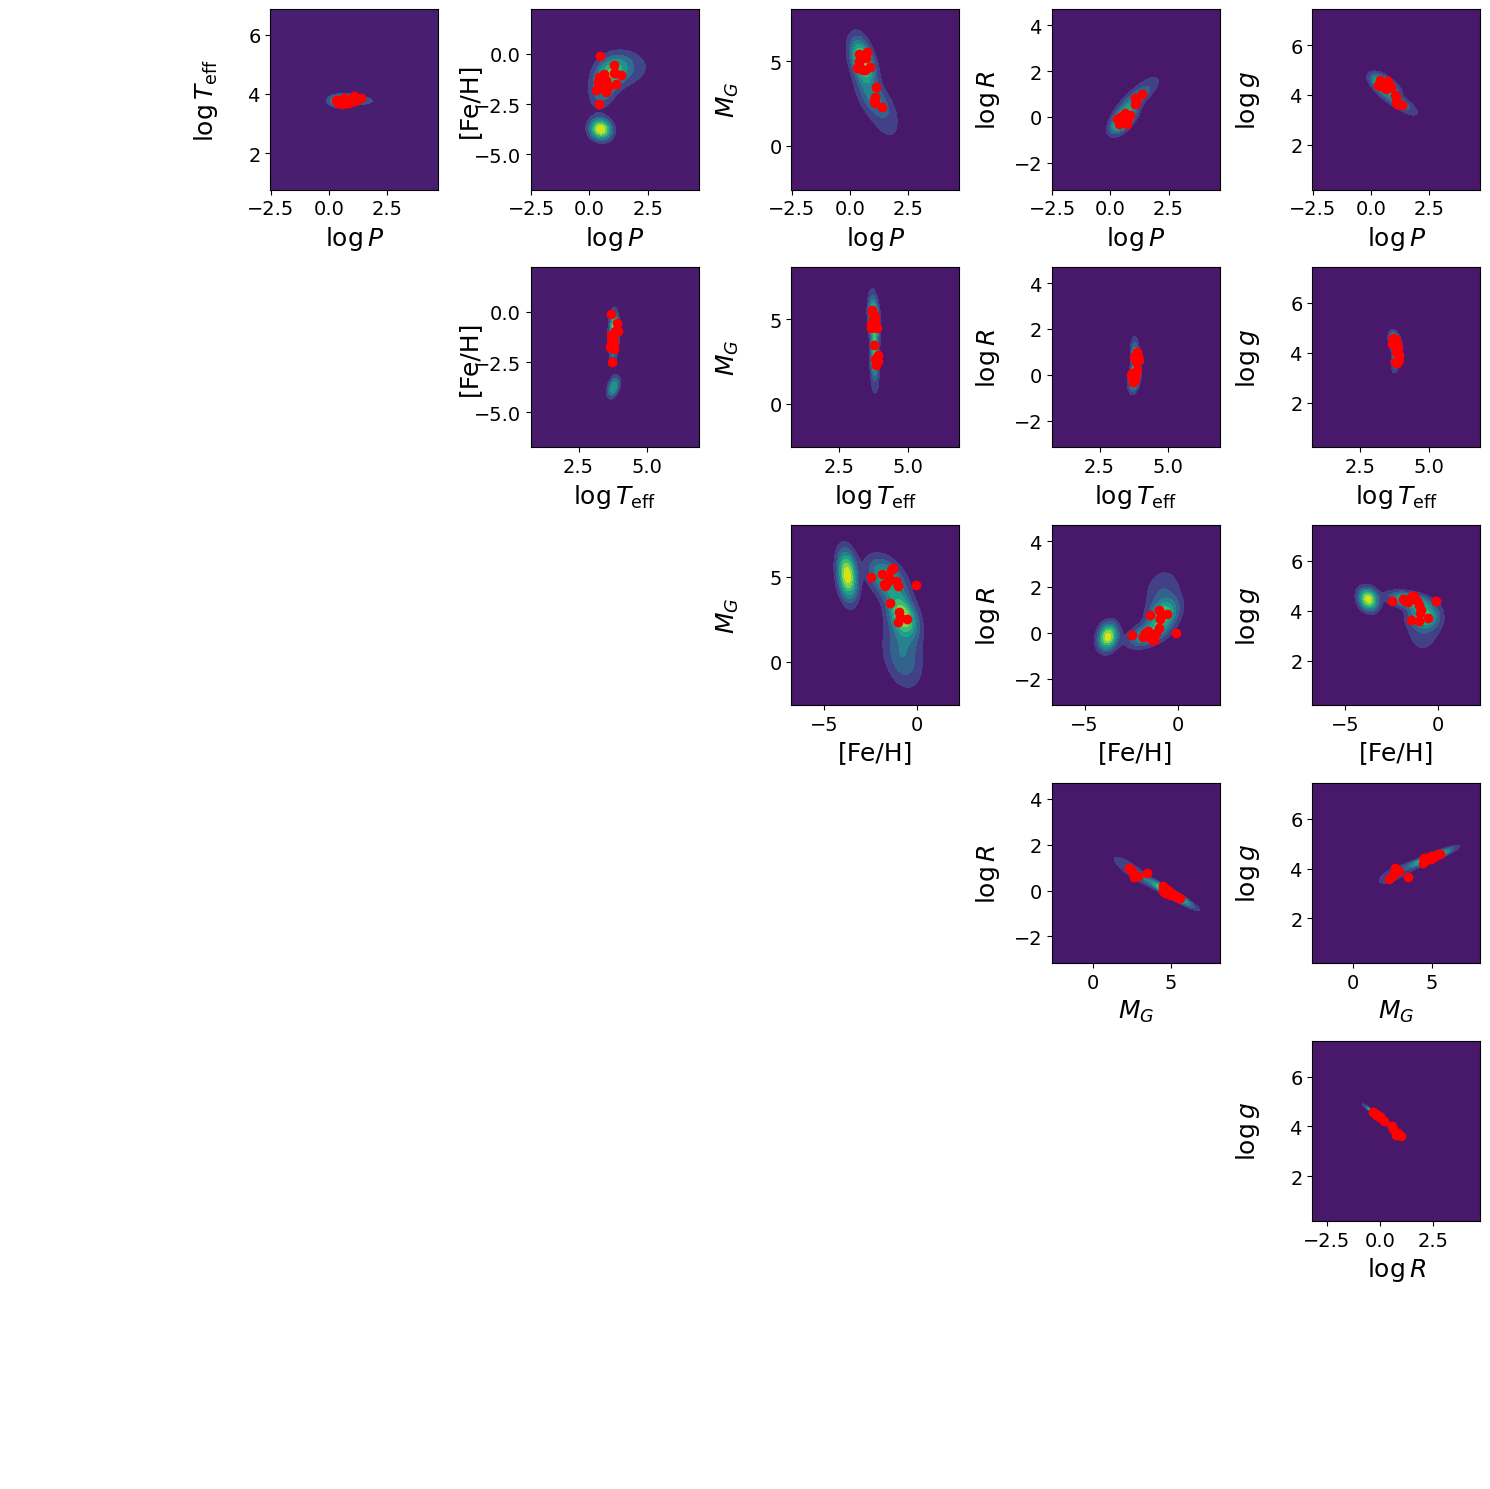

##################################################
star_class:  DSCT
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_DSCT_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_DSCT_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-1.8326,  8.9227,  0.    ,  2.225 ,  0.6675,  4.    ]),
                        n_components=2, random_state=42)
[0.7015 0.2985]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-1.8326,  8.9227,  0.    ,  2.225 ,  0.6675,  4.    ]),
                        n_components=2, random_state=42)
[[-2.0823  3.8923 -0.9814  1.8066  0.7681  3.9446]
 [-2.2539  3.7542 -2.3201  5.5619 -0.3136  4.5686]]
mode:  two_steps

Resampled Samples:
[[-1.9536  4.0208 -1.0893  2.9315  0.186   4.3536

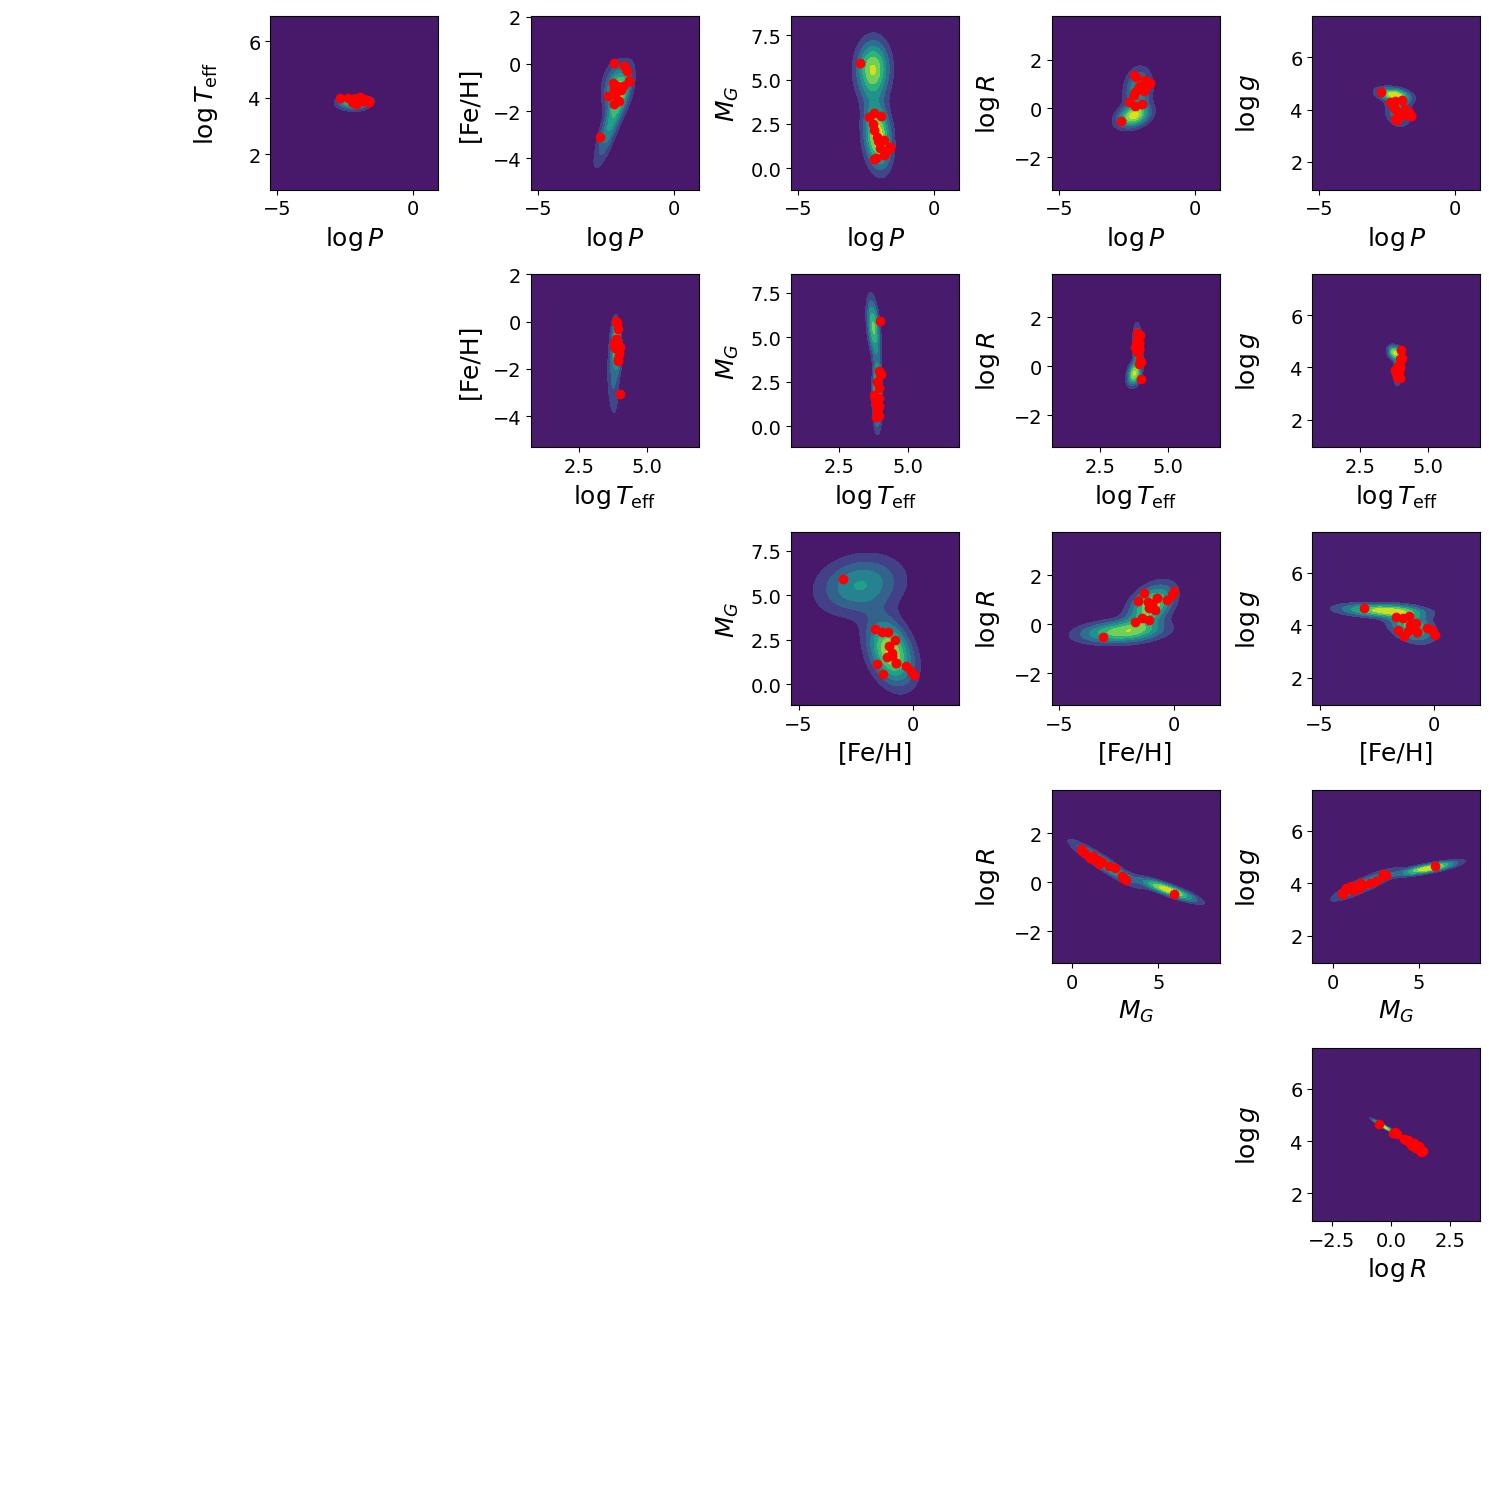

##################################################
star_class:  LPV
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_LPV_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_LPV_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([ 6.3099,  7.9194, -0.5   ,  0.25  ,  5.0106,  0.    ]),
                        random_state=42)
[1.]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([ 6.3099,  7.9194, -0.5   ,  0.25  ,  5.0106,  0.    ]),
                        random_state=42)
[[ 5.6831  3.5607 -0.0274 -2.3107  4.7316  0.5909]]
mode:  two_steps

Resampled Samples:
[[ 5.7177  3.564   0.1883 -0.2989  4.0429  0.9238]
 [ 6.0916  3.5626  0.3168 -3.9056  6.1501 -0.545 ]
 [ 5.693   3.4802  0.0537 -4.5675  5.5156  0

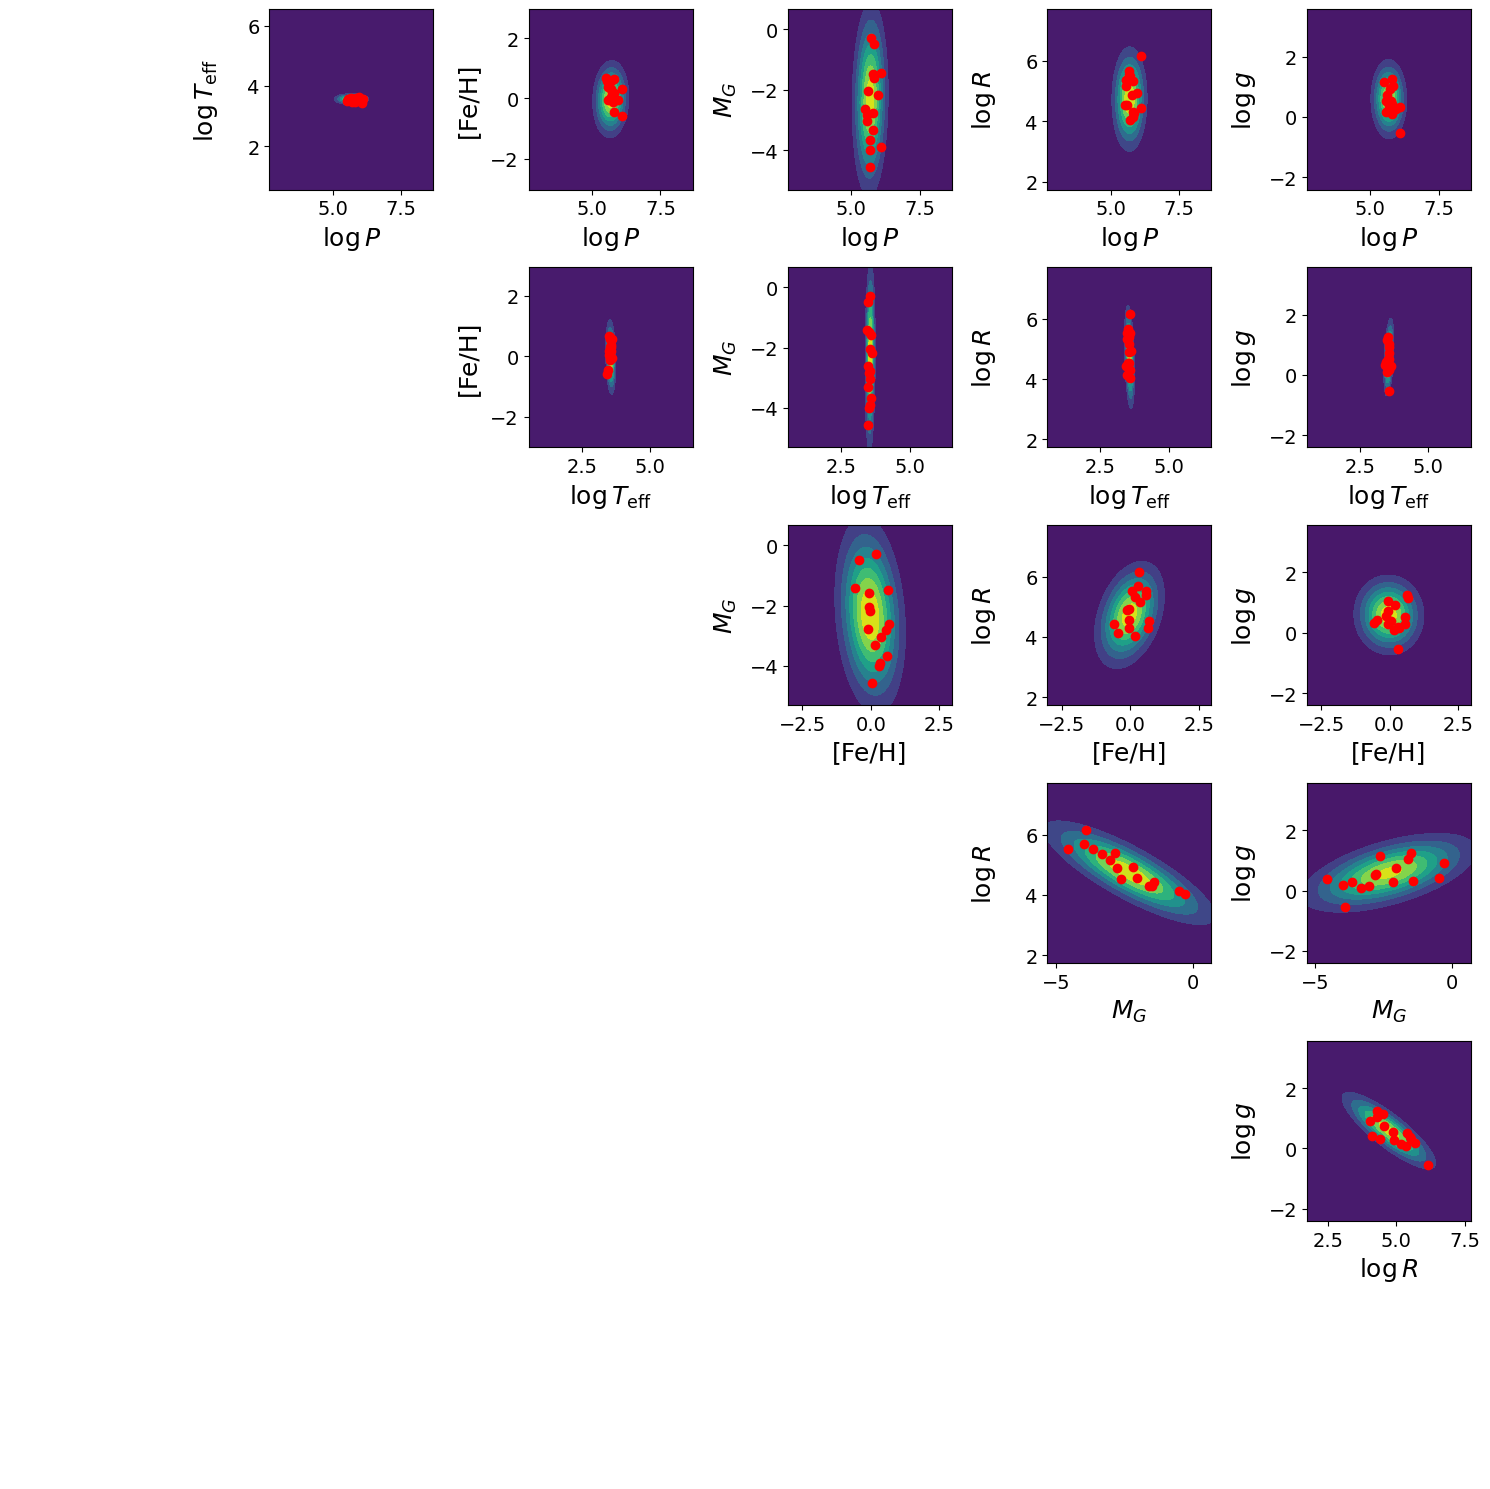

##################################################
star_class:  ECL
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_ECL_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_ECL_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([1.8925, 8.5841, 0.    , 1.35  , 0.2283, 3.8333]),
                        n_components=3, random_state=42)
[0.4009 0.2485 0.3507]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([1.8925, 8.5841, 0.    , 1.35  , 0.2283, 3.8333]),
                        n_components=3, random_state=42)
[[ 0.8567  3.8443 -0.5722  2.3848  0.7385  3.9146]
 [ 0.9866  4.259  -0.5656 -0.1198  0.7346  4.4395]
 [ 0.093   3.7192 -1.3951  5.5196 -0.1371  4.4348]]
mode:  two_steps

Resampled Samples:
[[-0.1

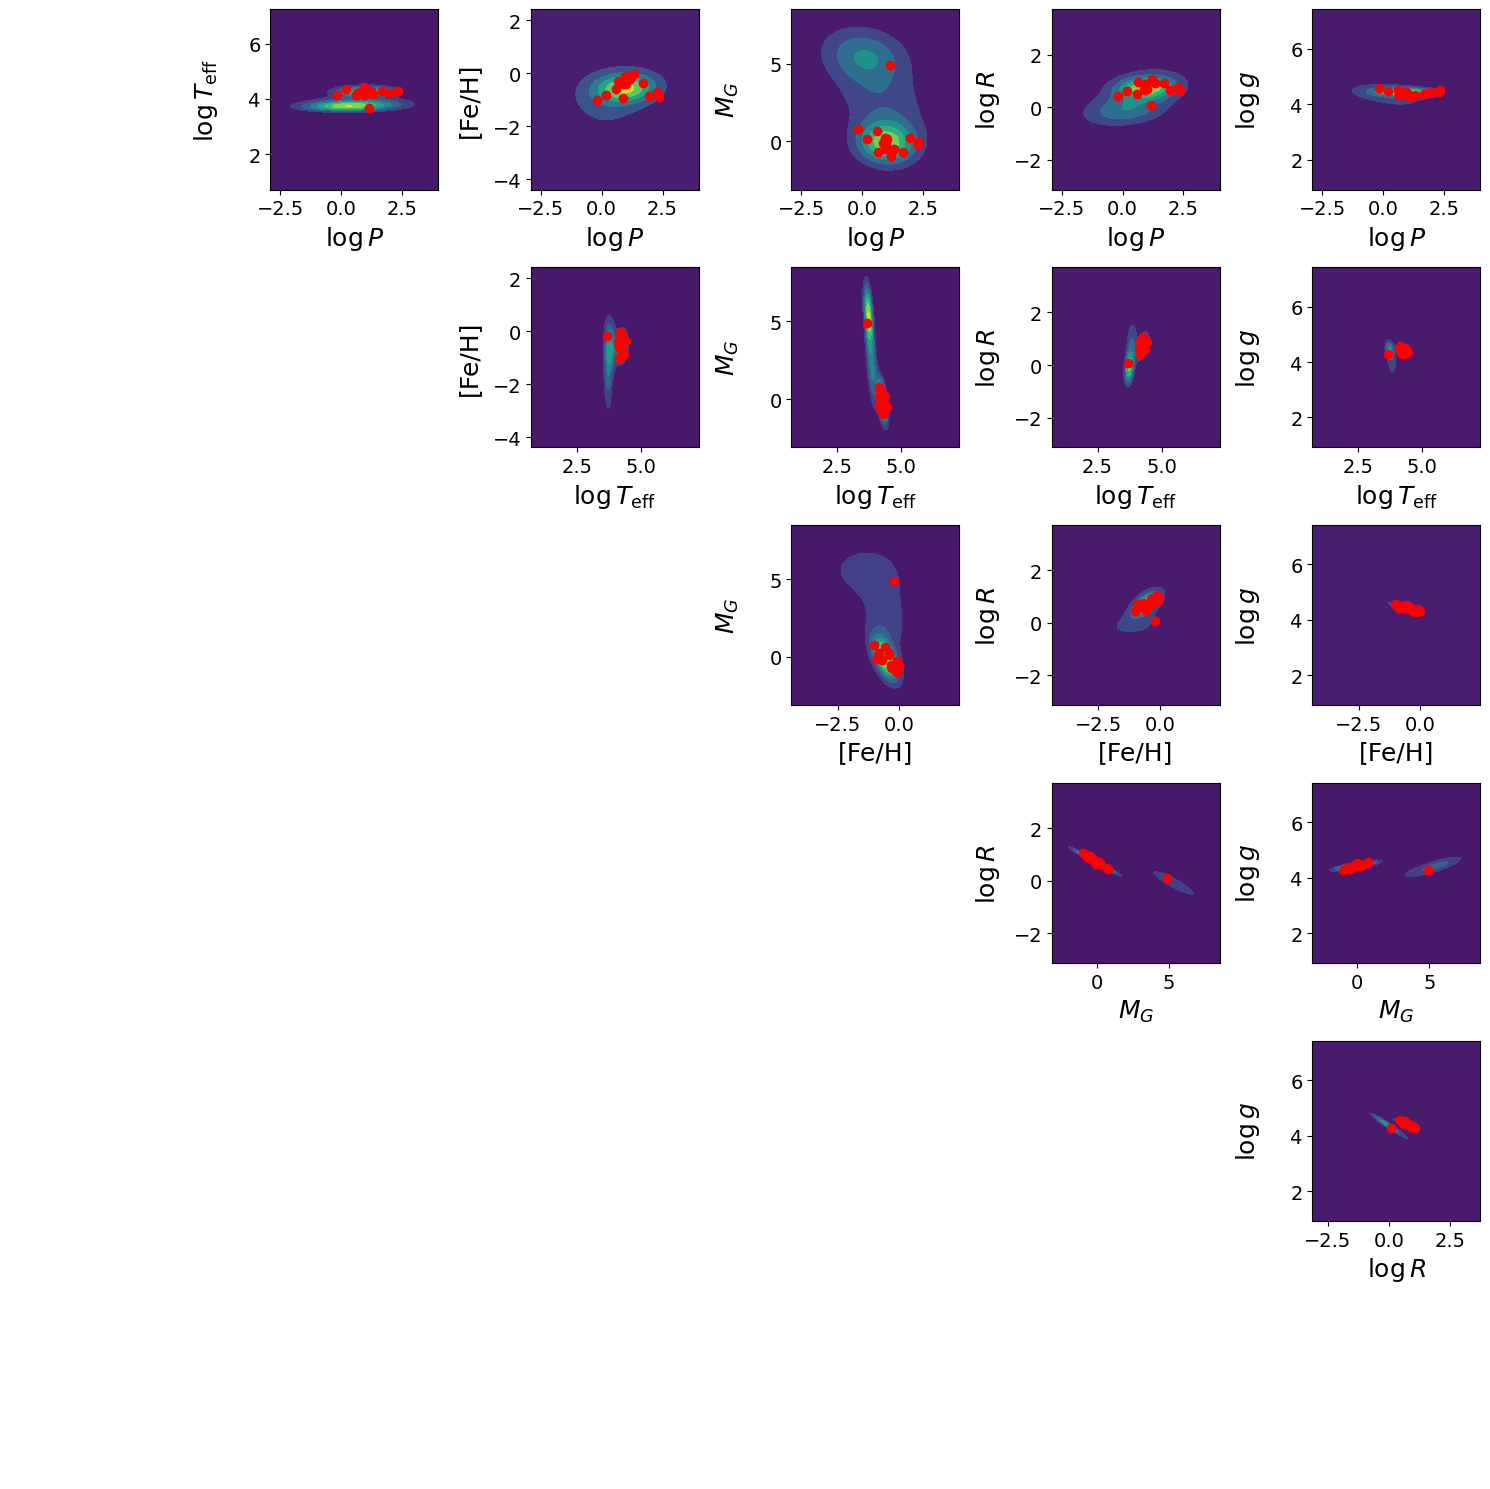

In [6]:
with open('src/gmm/priors.yaml', 'r') as file:
    priors = yaml.safe_load(file)

b = 1

for star_class in priors['StarTypes'].keys(): 
    
    if star_class in ['RRLYR', 'CEP', 'LPV', 'DSCT', 'ECL']:
        print('#'*50)
        print('star_class: ', star_class)
    
        components = len(priors['StarTypes'][star_class].keys())-3

    
        print('Initialization')
        sampler = ModifiedGaussianSampler(b=b, components=components, features=PP)

        print('sampler creation')

        batcher = SyntheticDataBatcher(pp = PP, vae_model=vae_model, n_samples=synthetic_samples_by_class, 
                                            seq_length = seq_length, prior=True)

        print('Synthetic batcher creation')

        model_name = batcher.construct_model_name(star_class, PATH_MODELS)

        print('model loading, ', model_name)

        samples, error = batcher.attempt_sample_load(model_name, sampler, n_samples=n_samples)

        sampler.plot_samples_densities(PP, samples, star_class)
        
        
        
        

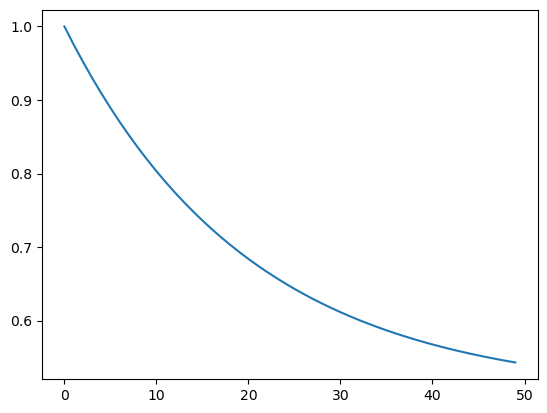

In [7]:
 plt.plot([0.5 + 0.5 * np.exp(-0.05 * epoch) for epoch in range(50)])

##################################################
star_class:  RRLYR
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_RRLYR_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_RRLYR_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-0.6183,  8.7947, -0.3   ,  0.6833, -0.2892,  3.    ]),
                        n_components=3, random_state=42)
[0.2773 0.5339 0.1889]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-0.6183,  8.7947, -0.3   ,  0.6833, -0.2892,  3.    ]),
                        n_components=3, random_state=42)
[[-0.7362  3.6227 -1.7233  7.4219 -0.4462  4.4166]
 [-0.7825  3.7335 -2.9479  5.8686 -0.3641  4.5768]
 [-0.7836  3.8451 -1.3124  2.4865  0.7175  3.8863]]
mode:  two_steps

Resampl

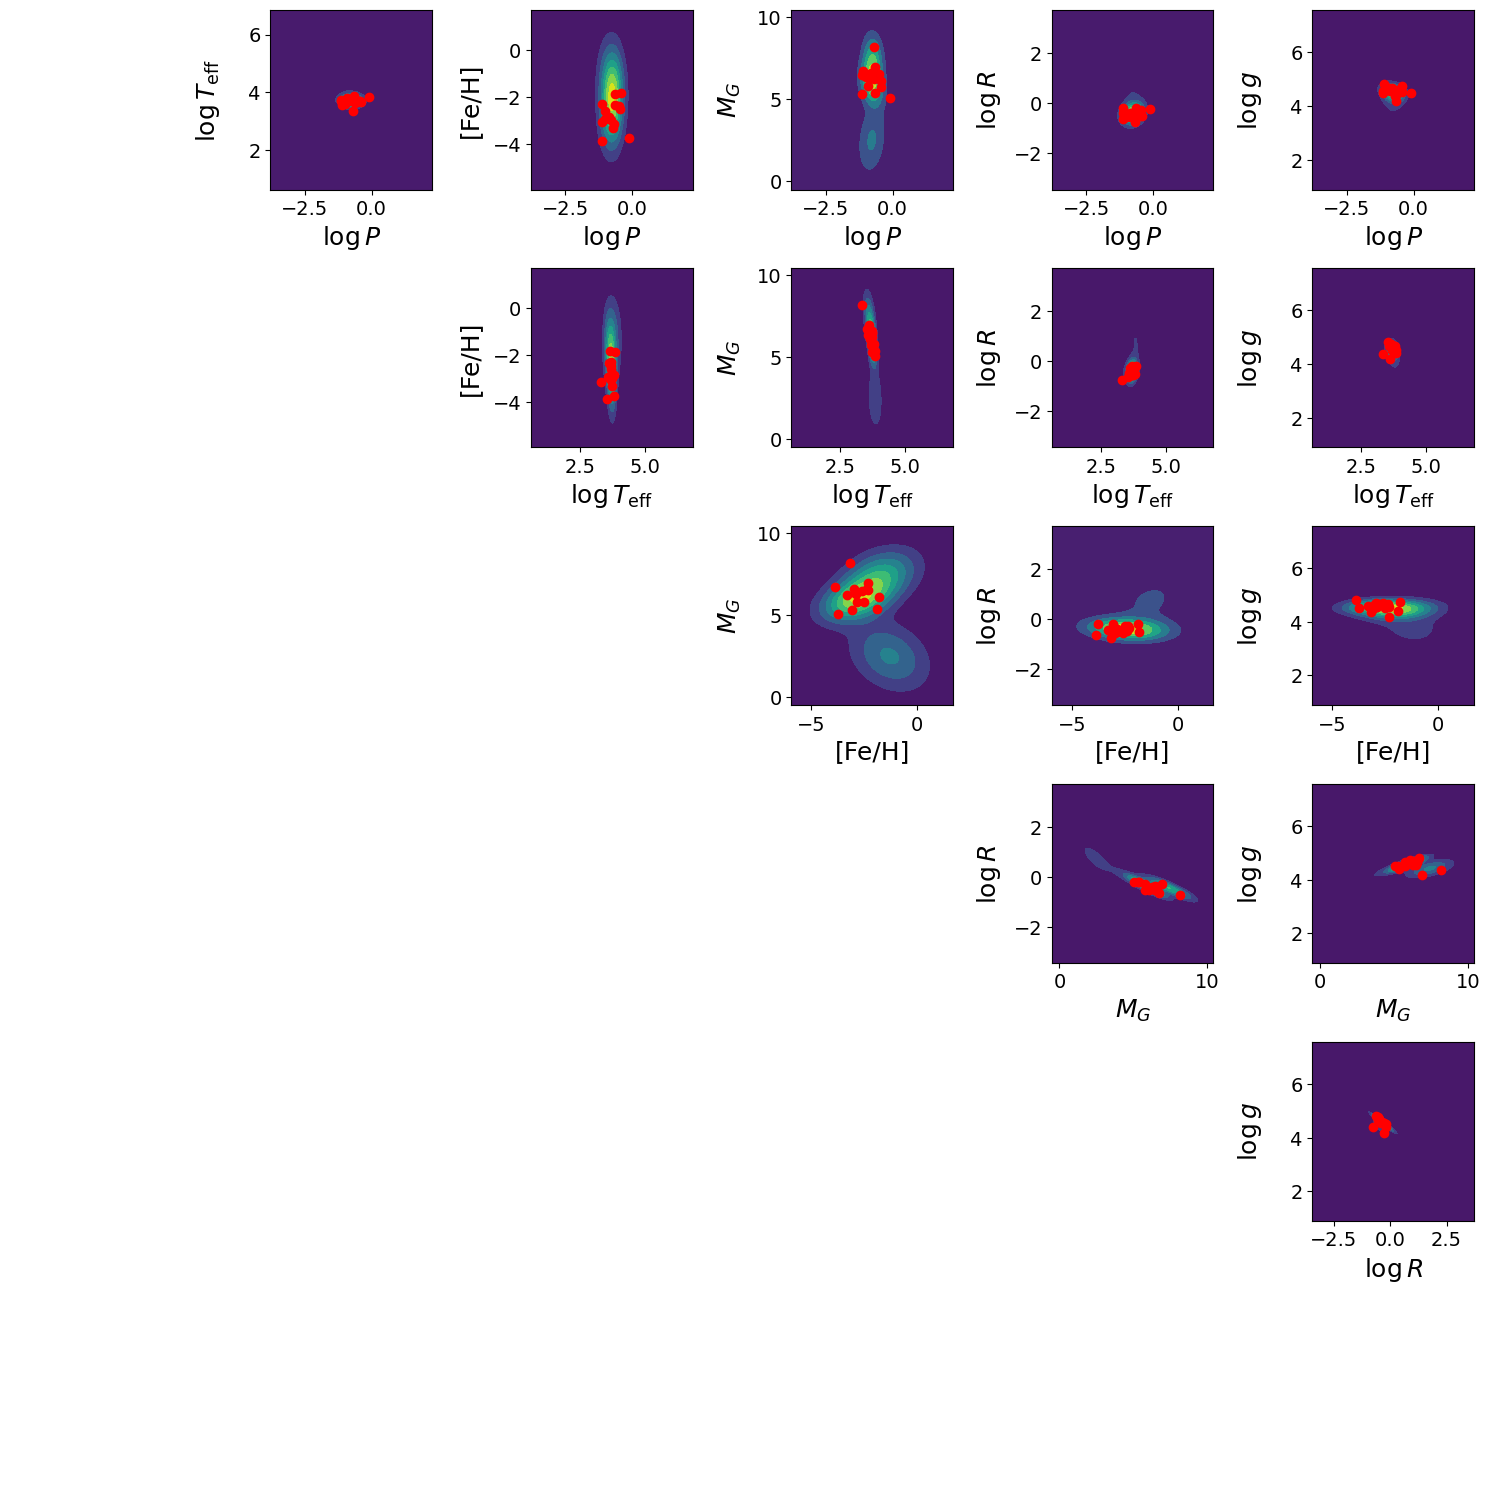

##################################################
star_class:  CEP
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_CEP_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_CEP_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([2.9114, 8.7853, 0.    , 0.    , 3.6217, 1.275 ]),
                        n_components=4, random_state=42)
[0.5303 0.146  0.0261 0.2976]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([2.9114, 8.7853, 0.    , 0.    , 3.6217, 1.275 ]),
                        n_components=4, random_state=42)
[[ 1.094   3.7909 -0.7561  2.6847  0.7982  3.7914]
 [ 0.4873  3.771  -3.7535  5.0978 -0.1712  4.4524]
 [ 1.6934  3.8754 -0.7959  0.409   1.7181  3.2054]
 [ 0.5986  3.7656 -1.6281  4.9092 -0.

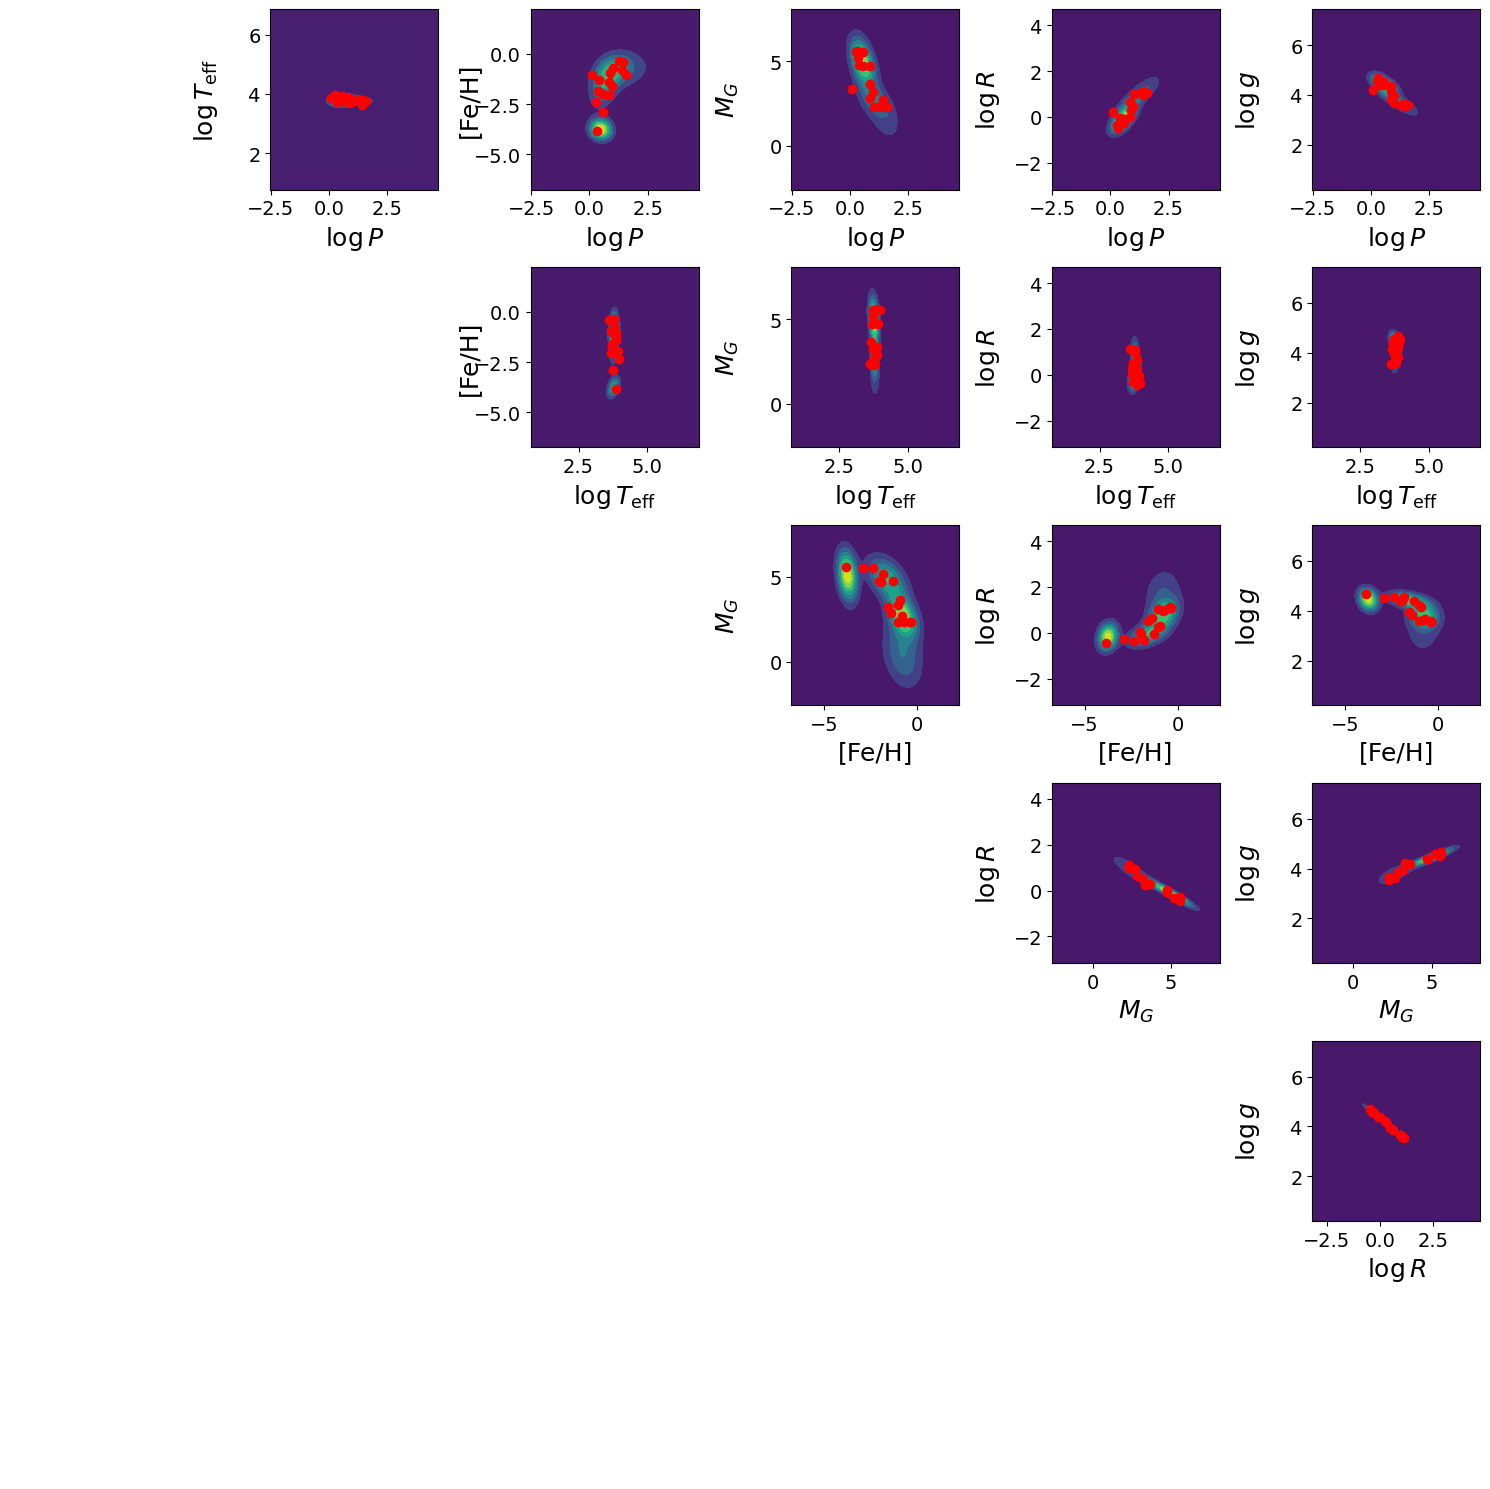

##################################################
star_class:  DSCT
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_DSCT_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_DSCT_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-1.8326,  8.9227,  0.    ,  2.225 ,  0.6675,  4.    ]),
                        n_components=2, random_state=42)
[0.7015 0.2985]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-1.8326,  8.9227,  0.    ,  2.225 ,  0.6675,  4.    ]),
                        n_components=2, random_state=42)
[[-2.0823  3.8923 -0.9814  1.8066  0.7681  3.9446]
 [-2.2539  3.7542 -2.3201  5.5619 -0.3136  4.5686]]
mode:  two_steps

Resampled Samples:
[[-1.8585  3.9537 -0.9357  1.5695  0.729   4.0274

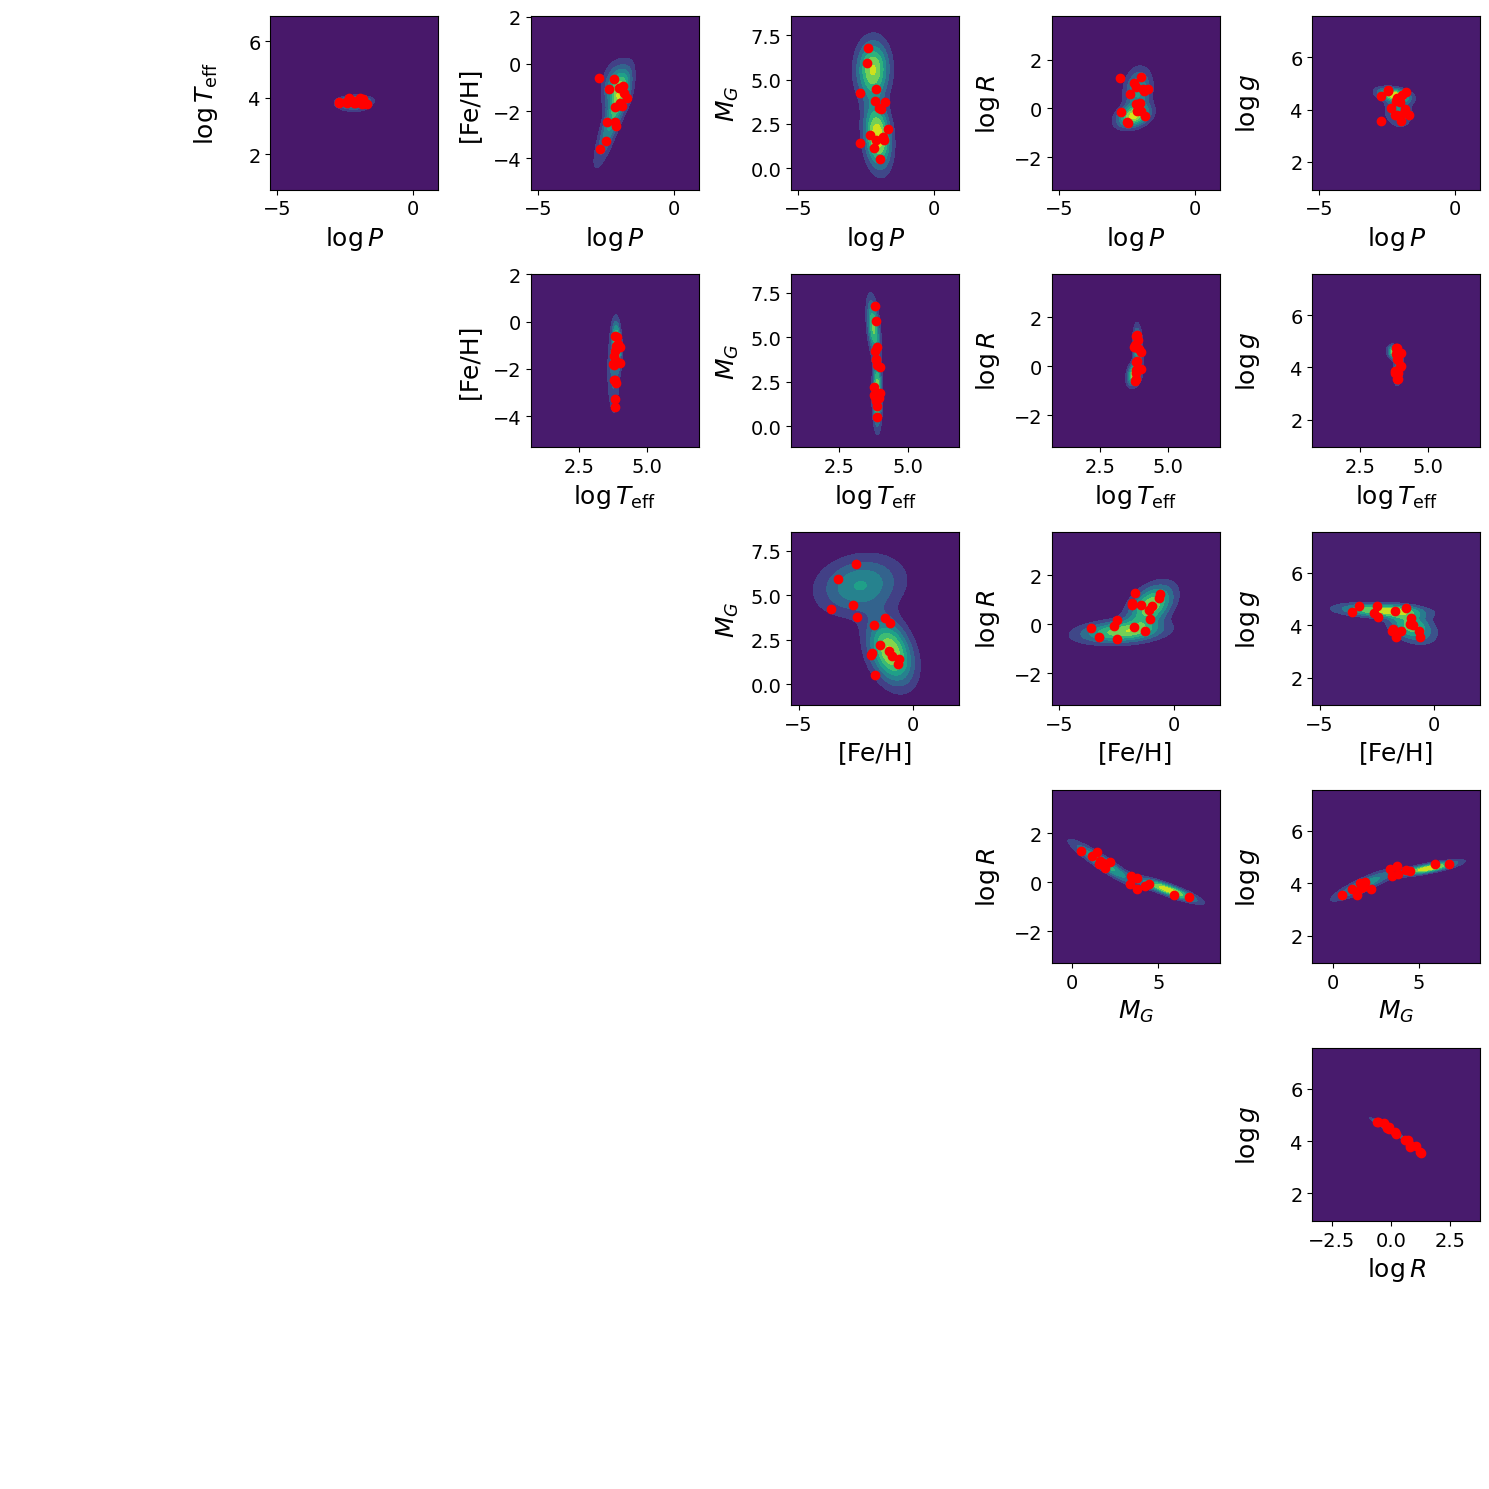

##################################################
star_class:  LPV
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_LPV_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_LPV_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([ 6.3099,  7.9194, -0.5   ,  0.25  ,  5.0106,  0.    ]),
                        random_state=42)
[1.]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([ 6.3099,  7.9194, -0.5   ,  0.25  ,  5.0106,  0.    ]),
                        random_state=42)
[[ 5.6831  3.5607 -0.0274 -2.3107  4.7316  0.5909]]
mode:  two_steps

Resampled Samples:
[[ 5.5842  3.5722  0.2907 -0.5681  3.5642  1.7462]
 [ 5.4268  3.5467 -0.4416 -3.5633  4.3719  1.14  ]
 [ 5.6283  3.5735  0.1464 -0.9395  3.3425  1

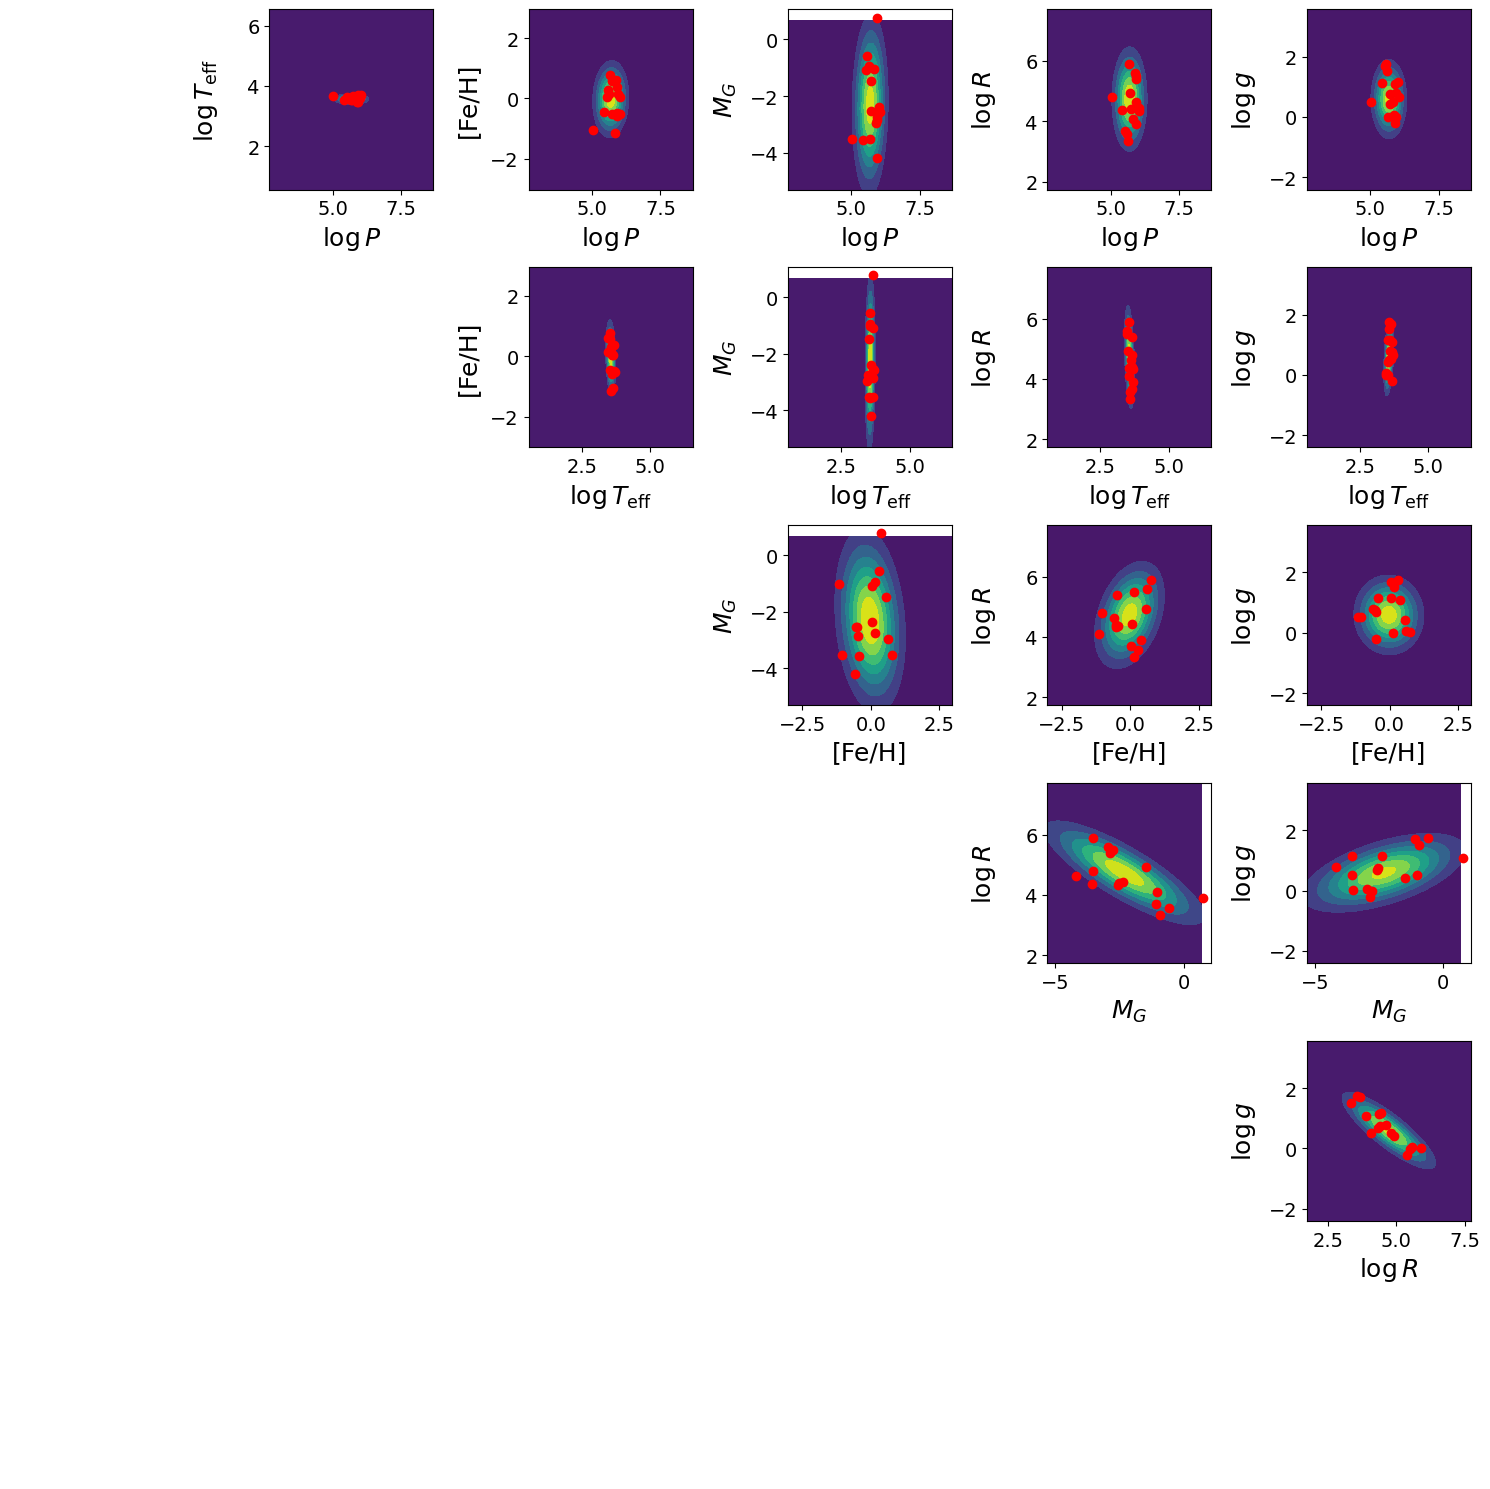

##################################################
star_class:  ECL
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_ECL_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_ECL_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([1.8925, 8.5841, 0.    , 1.35  , 0.2283, 3.8333]),
                        n_components=3, random_state=42)
[0.4009 0.2485 0.3507]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([1.8925, 8.5841, 0.    , 1.35  , 0.2283, 3.8333]),
                        n_components=3, random_state=42)
[[ 0.8567  3.8443 -0.5722  2.3848  0.7385  3.9146]
 [ 0.9866  4.259  -0.5656 -0.1198  0.7346  4.4395]
 [ 0.093   3.7192 -1.3951  5.5196 -0.1371  4.4348]]
mode:  two_steps

Resampled Samples:
[[ 1.9

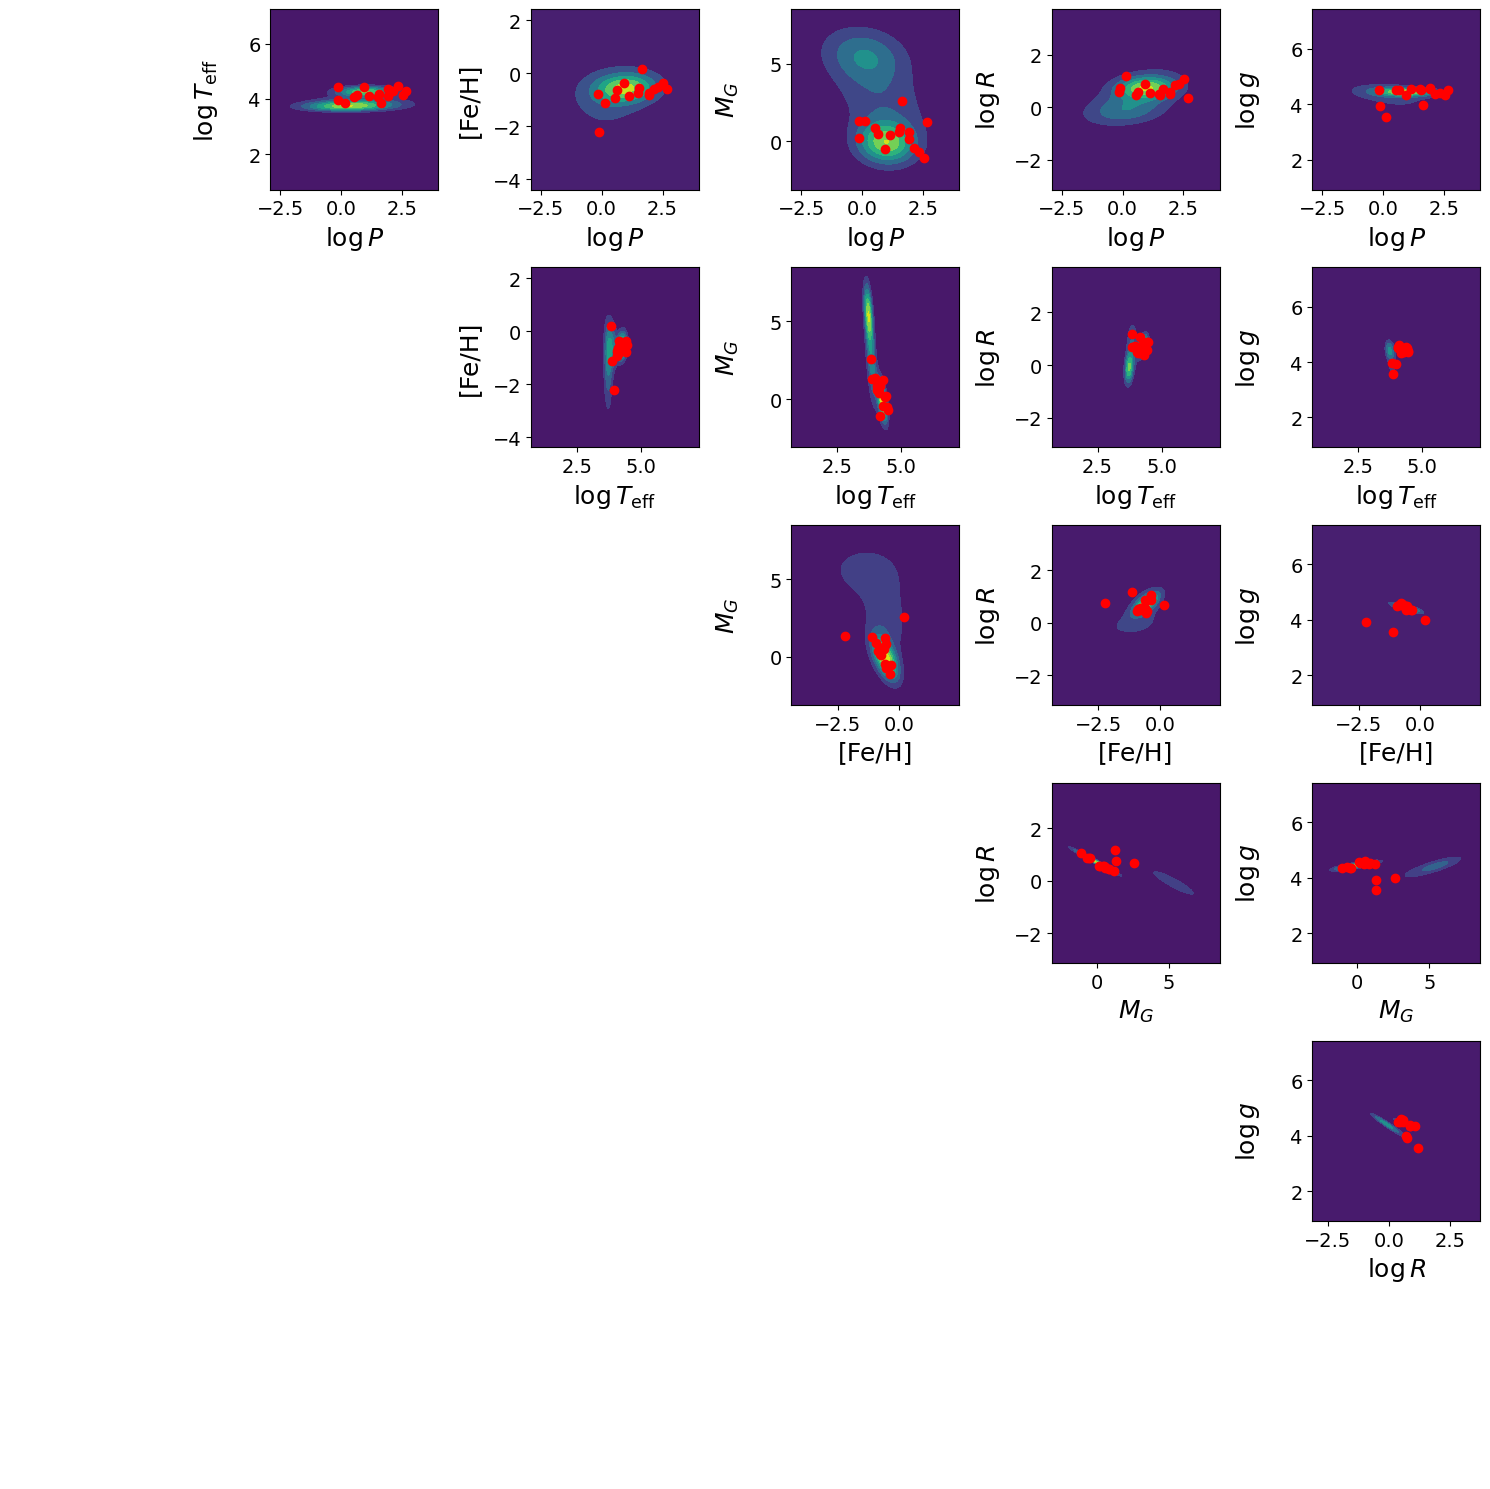

In [8]:
with open('src/gmm/priors.yaml', 'r') as file:
    priors = yaml.safe_load(file)

b = 0.5

for star_class in priors['StarTypes'].keys(): 
    
    if star_class in ['RRLYR', 'CEP', 'LPV', 'DSCT', 'ECL']:
        print('#'*50)
        print('star_class: ', star_class)
    
        components = len(priors['StarTypes'][star_class].keys())-3

    
        print('Initialization')
        sampler = ModifiedGaussianSampler(b=b, components=components, features=PP)

        print('sampler creation')

        batcher = SyntheticDataBatcher(pp = PP, vae_model=vae_model, n_samples=synthetic_samples_by_class, 
                                            seq_length = seq_length, prior=True)

        print('Synthetic batcher creation')

        model_name = batcher.construct_model_name(star_class, PATH_MODELS)

        print('model loading, ', model_name)

        samples, error = batcher.attempt_sample_load(model_name, sampler, n_samples=n_samples)

        sampler.plot_samples_densities(PP, samples, star_class)

##################################################
star_class:  RRLYR
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_RRLYR_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_RRLYR_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-0.6183,  8.7947, -0.3   ,  0.6833, -0.2892,  3.    ]),
                        n_components=3, random_state=42)
[0.2773 0.5339 0.1889]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-0.6183,  8.7947, -0.3   ,  0.6833, -0.2892,  3.    ]),
                        n_components=3, random_state=42)
[[-0.7362  3.6227 -1.7233  7.4219 -0.4462  4.4166]
 [-0.7825  3.7335 -2.9479  5.8686 -0.3641  4.5768]
 [-0.7836  3.8451 -1.3124  2.4865  0.7175  3.8863]]
mode:  two_steps

Resampl

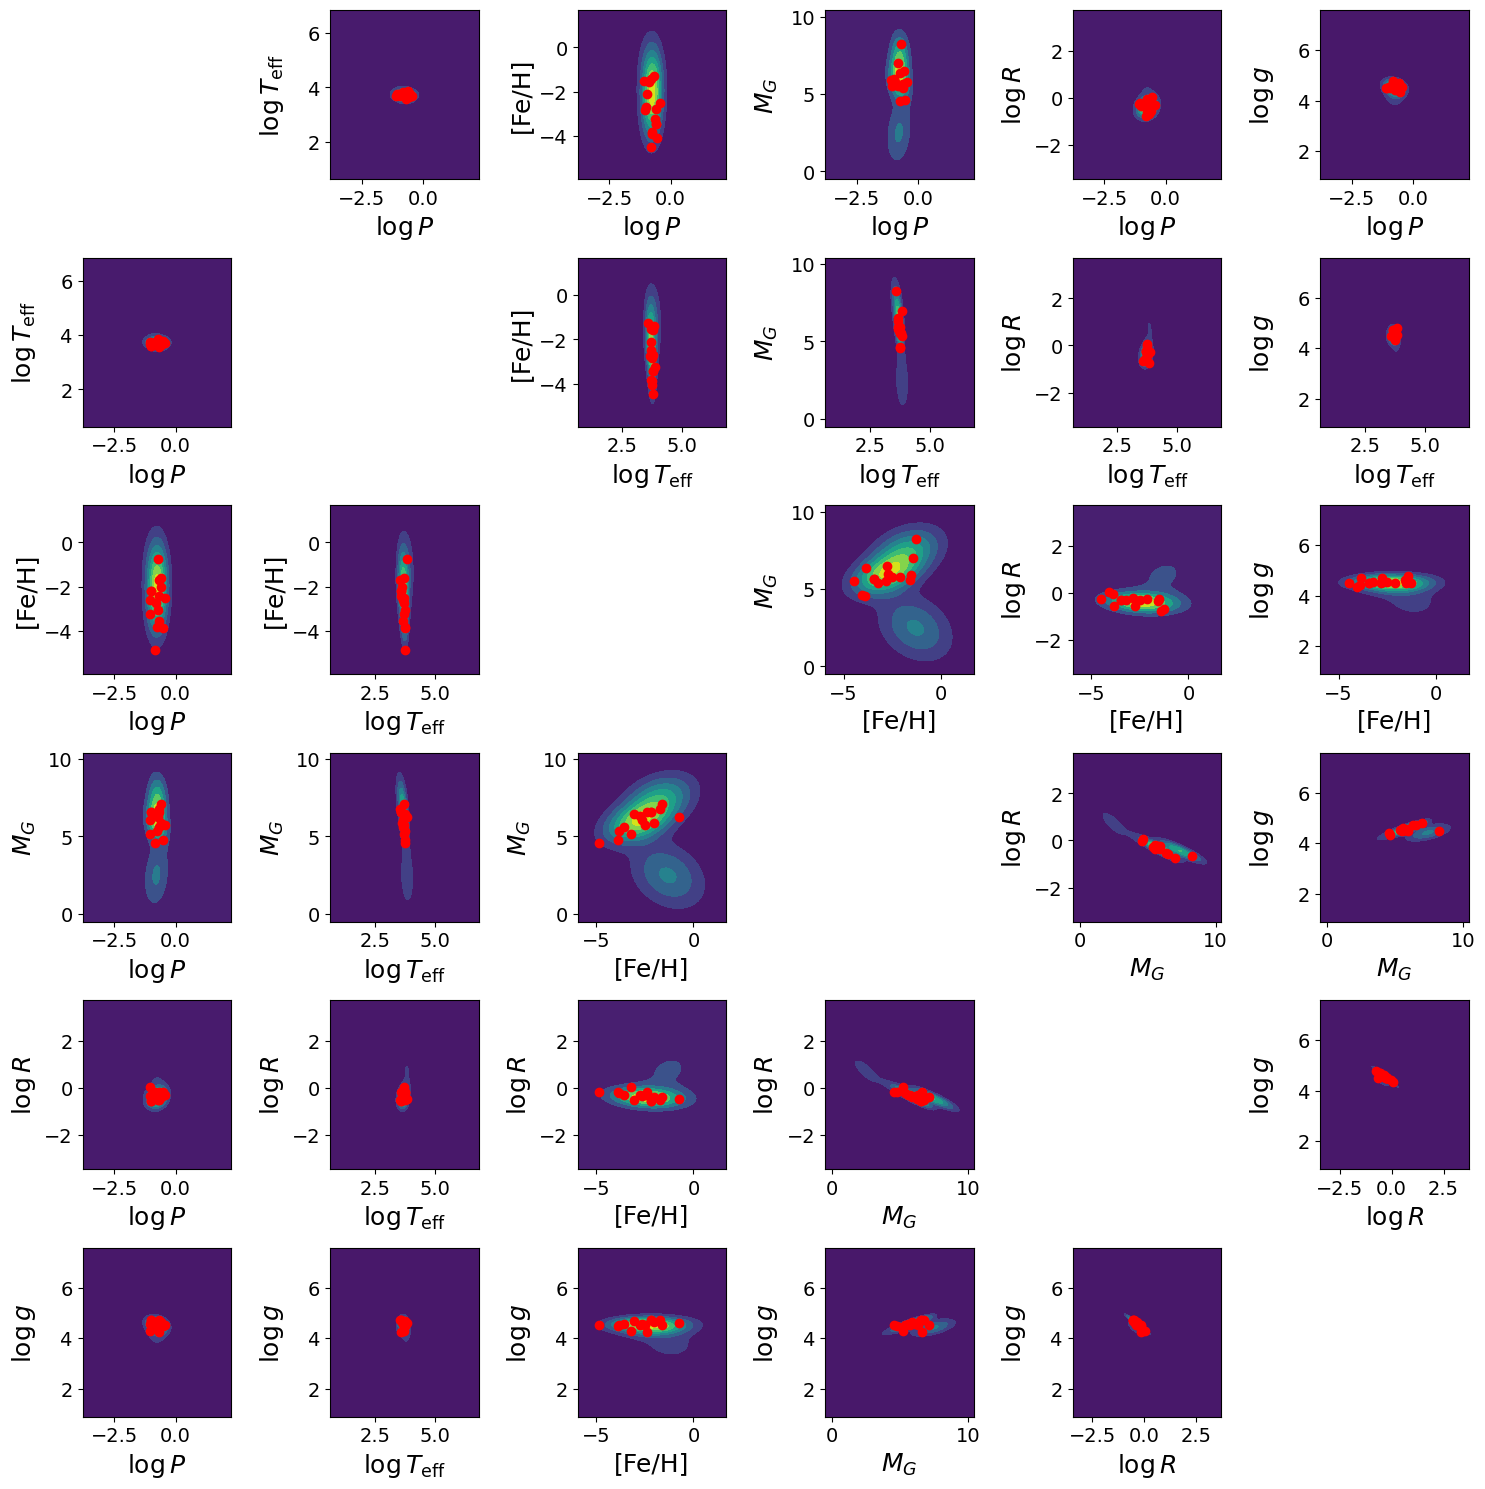

##################################################
star_class:  CEP
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_CEP_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_CEP_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([2.9114, 8.7853, 0.    , 0.    , 3.6217, 1.275 ]),
                        n_components=4, random_state=42)
[0.5303 0.146  0.0261 0.2976]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([2.9114, 8.7853, 0.    , 0.    , 3.6217, 1.275 ]),
                        n_components=4, random_state=42)
[[ 1.094   3.7909 -0.7561  2.6847  0.7982  3.7914]
 [ 0.4873  3.771  -3.7535  5.0978 -0.1712  4.4524]
 [ 1.6934  3.8754 -0.7959  0.409   1.7181  3.2054]
 [ 0.5986  3.7656 -1.6281  4.9092 -0.

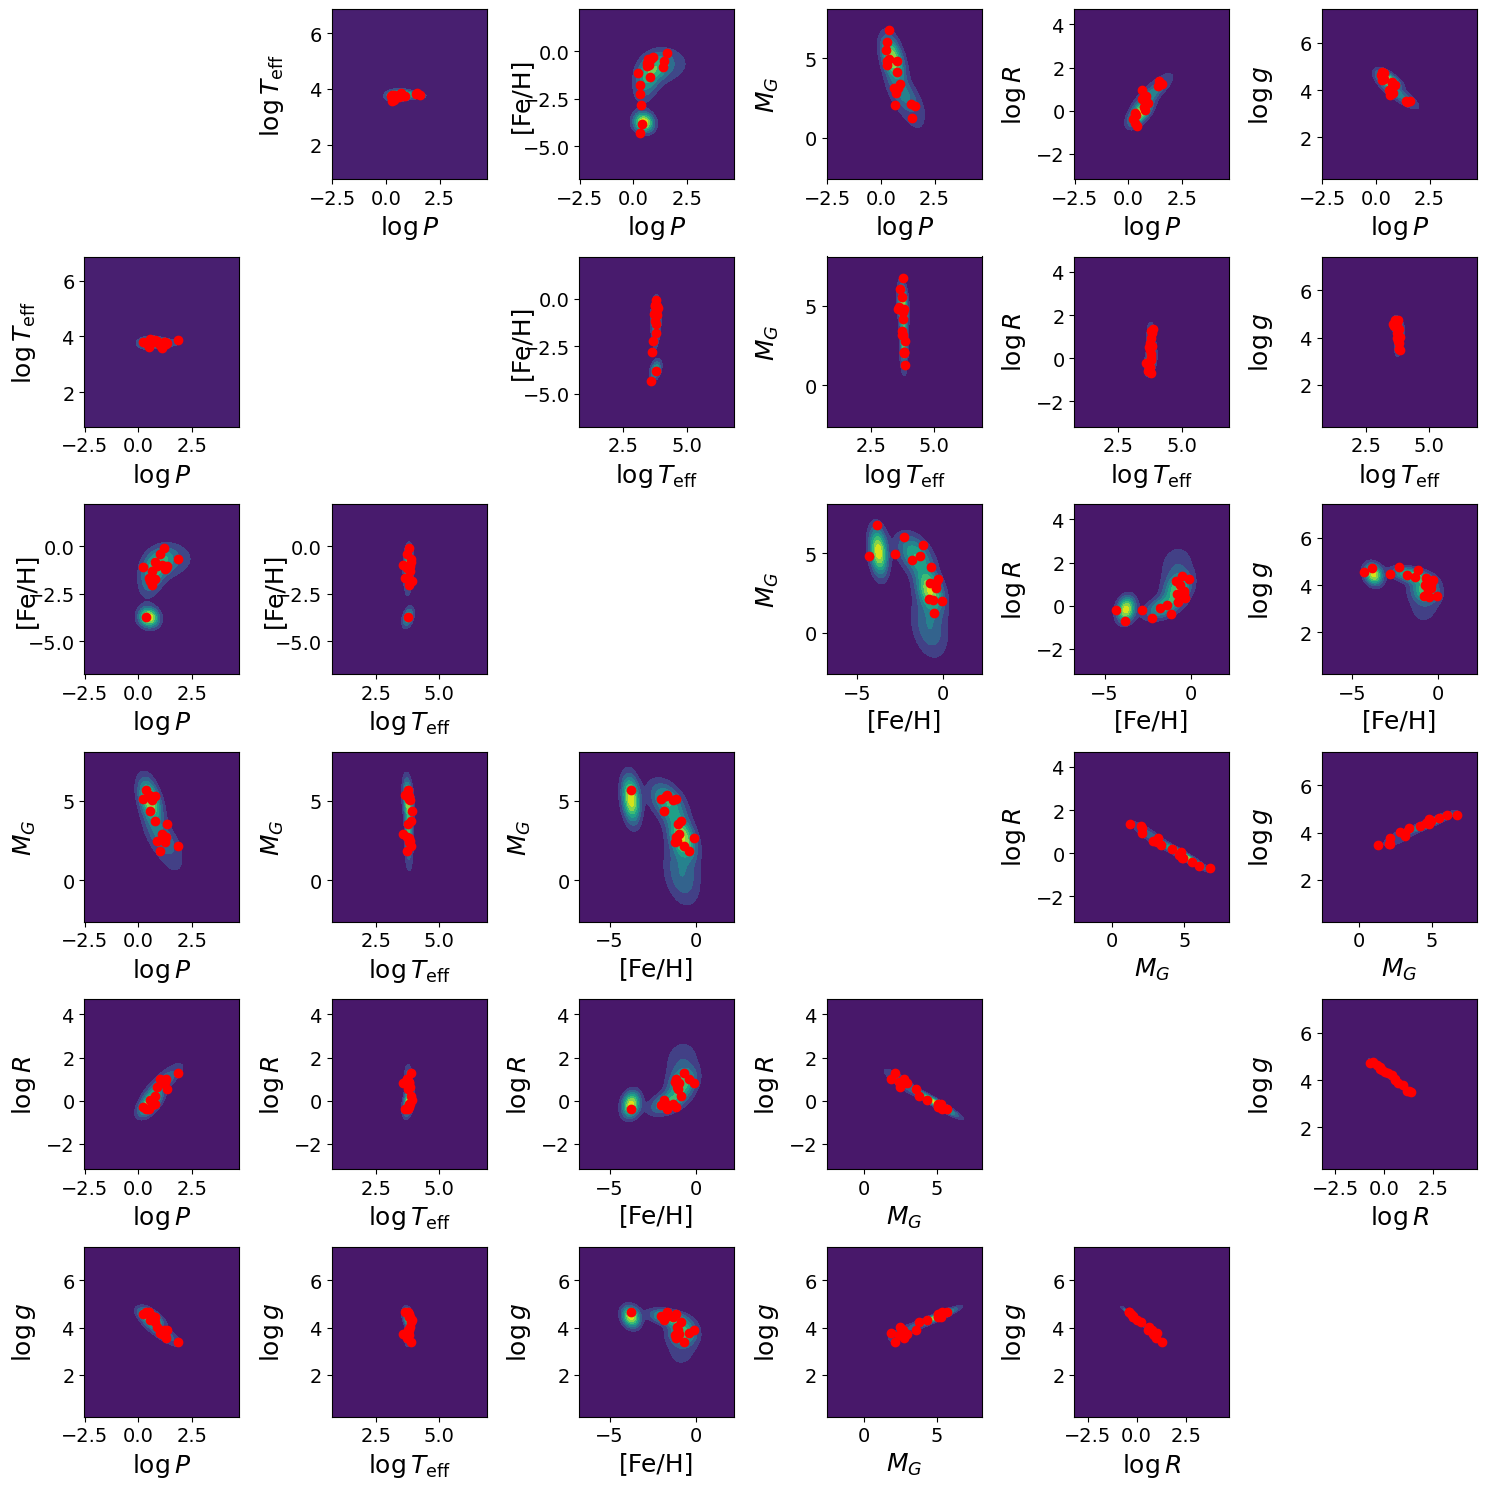

##################################################
star_class:  DSCT
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_DSCT_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_DSCT_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-1.8326,  8.9227,  0.    ,  2.225 ,  0.6675,  4.    ]),
                        n_components=2, random_state=42)
[0.7015 0.2985]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([-1.8326,  8.9227,  0.    ,  2.225 ,  0.6675,  4.    ]),
                        n_components=2, random_state=42)
[[-2.0823  3.8923 -0.9814  1.8066  0.7681  3.9446]
 [-2.2539  3.7542 -2.3201  5.5619 -0.3136  4.5686]]
mode:  two_steps

Resampled Samples:
[[-2.3817  4.0625 -2.7042  5.2353 -0.2584  4.5484

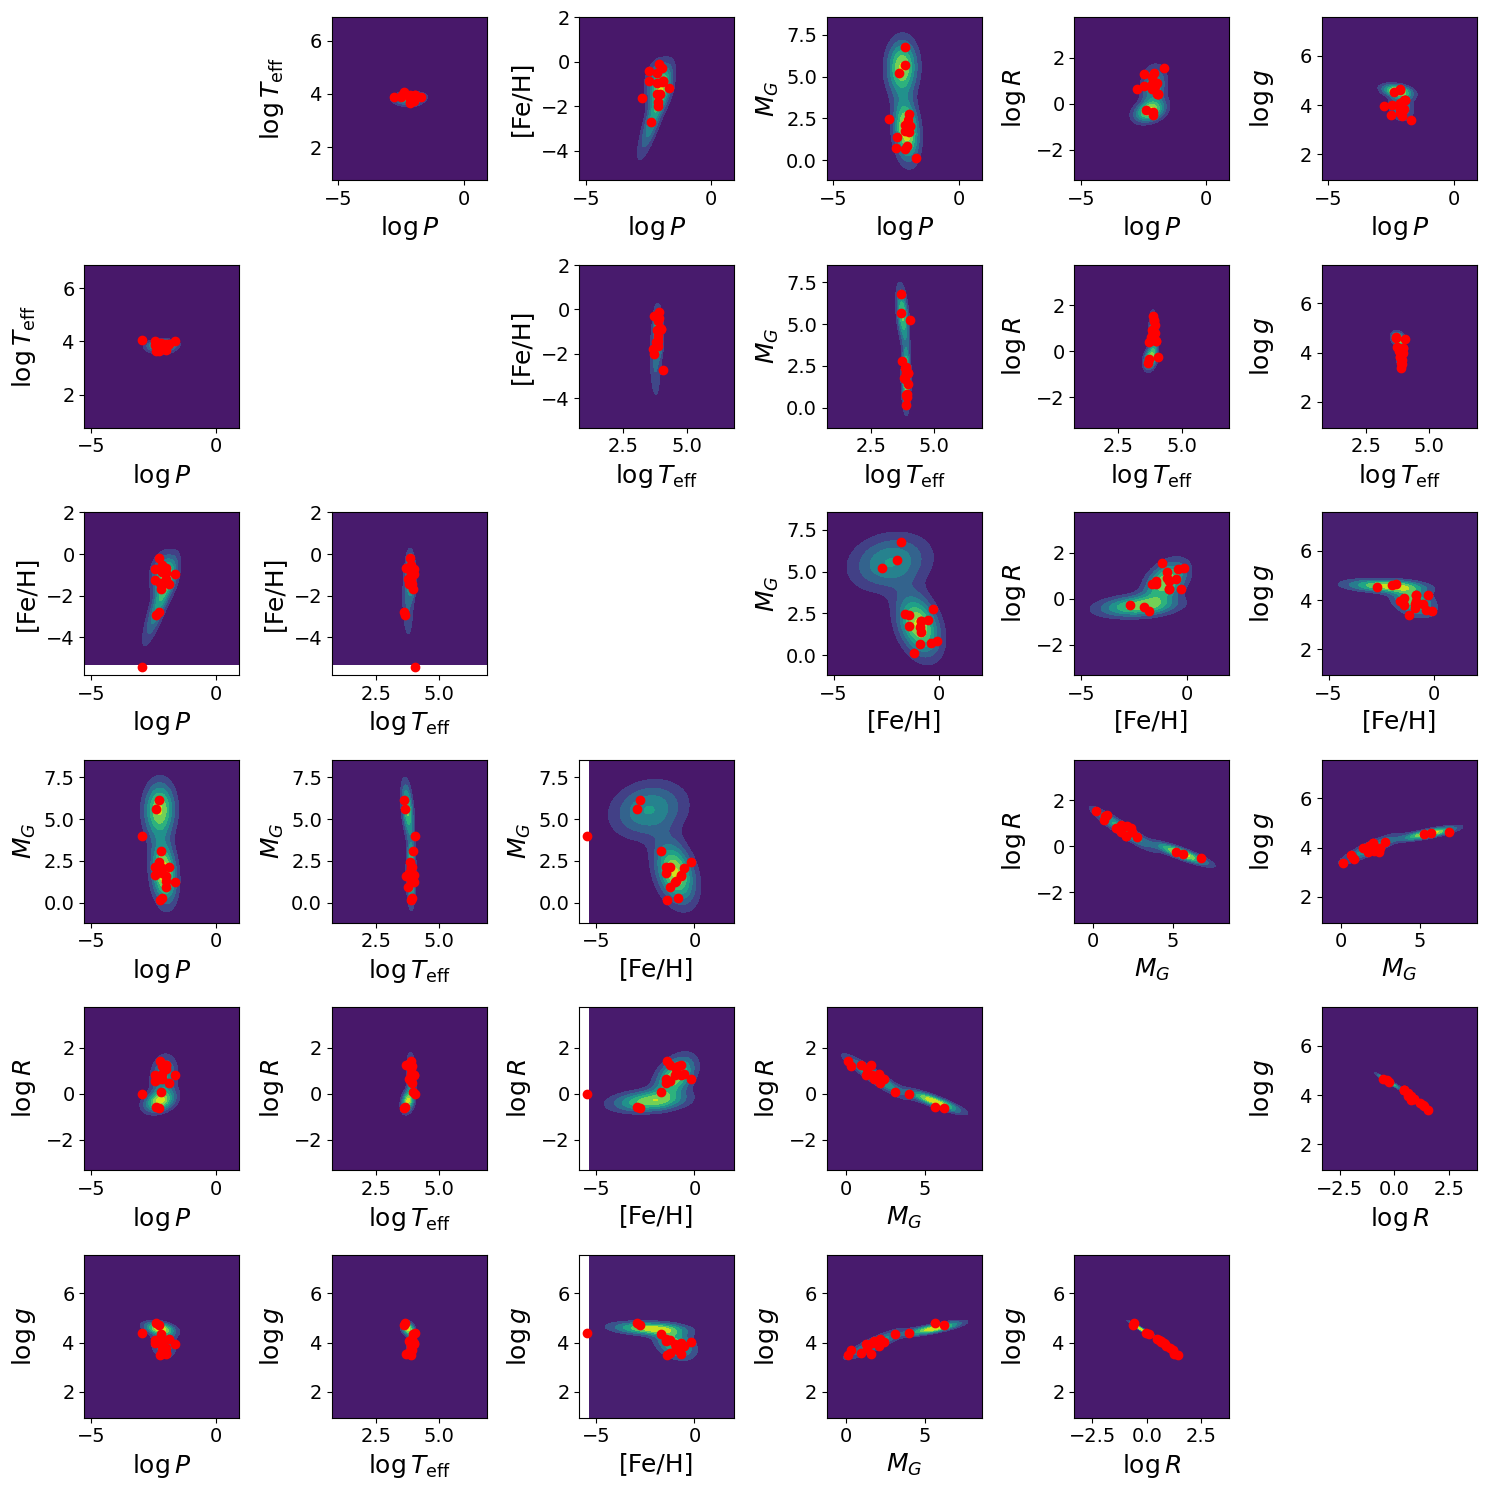

##################################################
star_class:  LPV
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_LPV_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_LPV_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([ 6.3099,  7.9194, -0.5   ,  0.25  ,  5.0106,  0.    ]),
                        random_state=42)
[1.]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([ 6.3099,  7.9194, -0.5   ,  0.25  ,  5.0106,  0.    ]),
                        random_state=42)
[[ 5.6831  3.5607 -0.0274 -2.3107  4.7316  0.5909]]
mode:  two_steps

Resampled Samples:
[[ 6.0689  3.5463 -0.3228 -1.6715  4.4874  0.6614]
 [ 5.069   3.5841 -0.9013 -2.5006  4.2218  0.8252]
 [ 5.7062  3.6249 -1.0177 -2.3202  4.2619  0

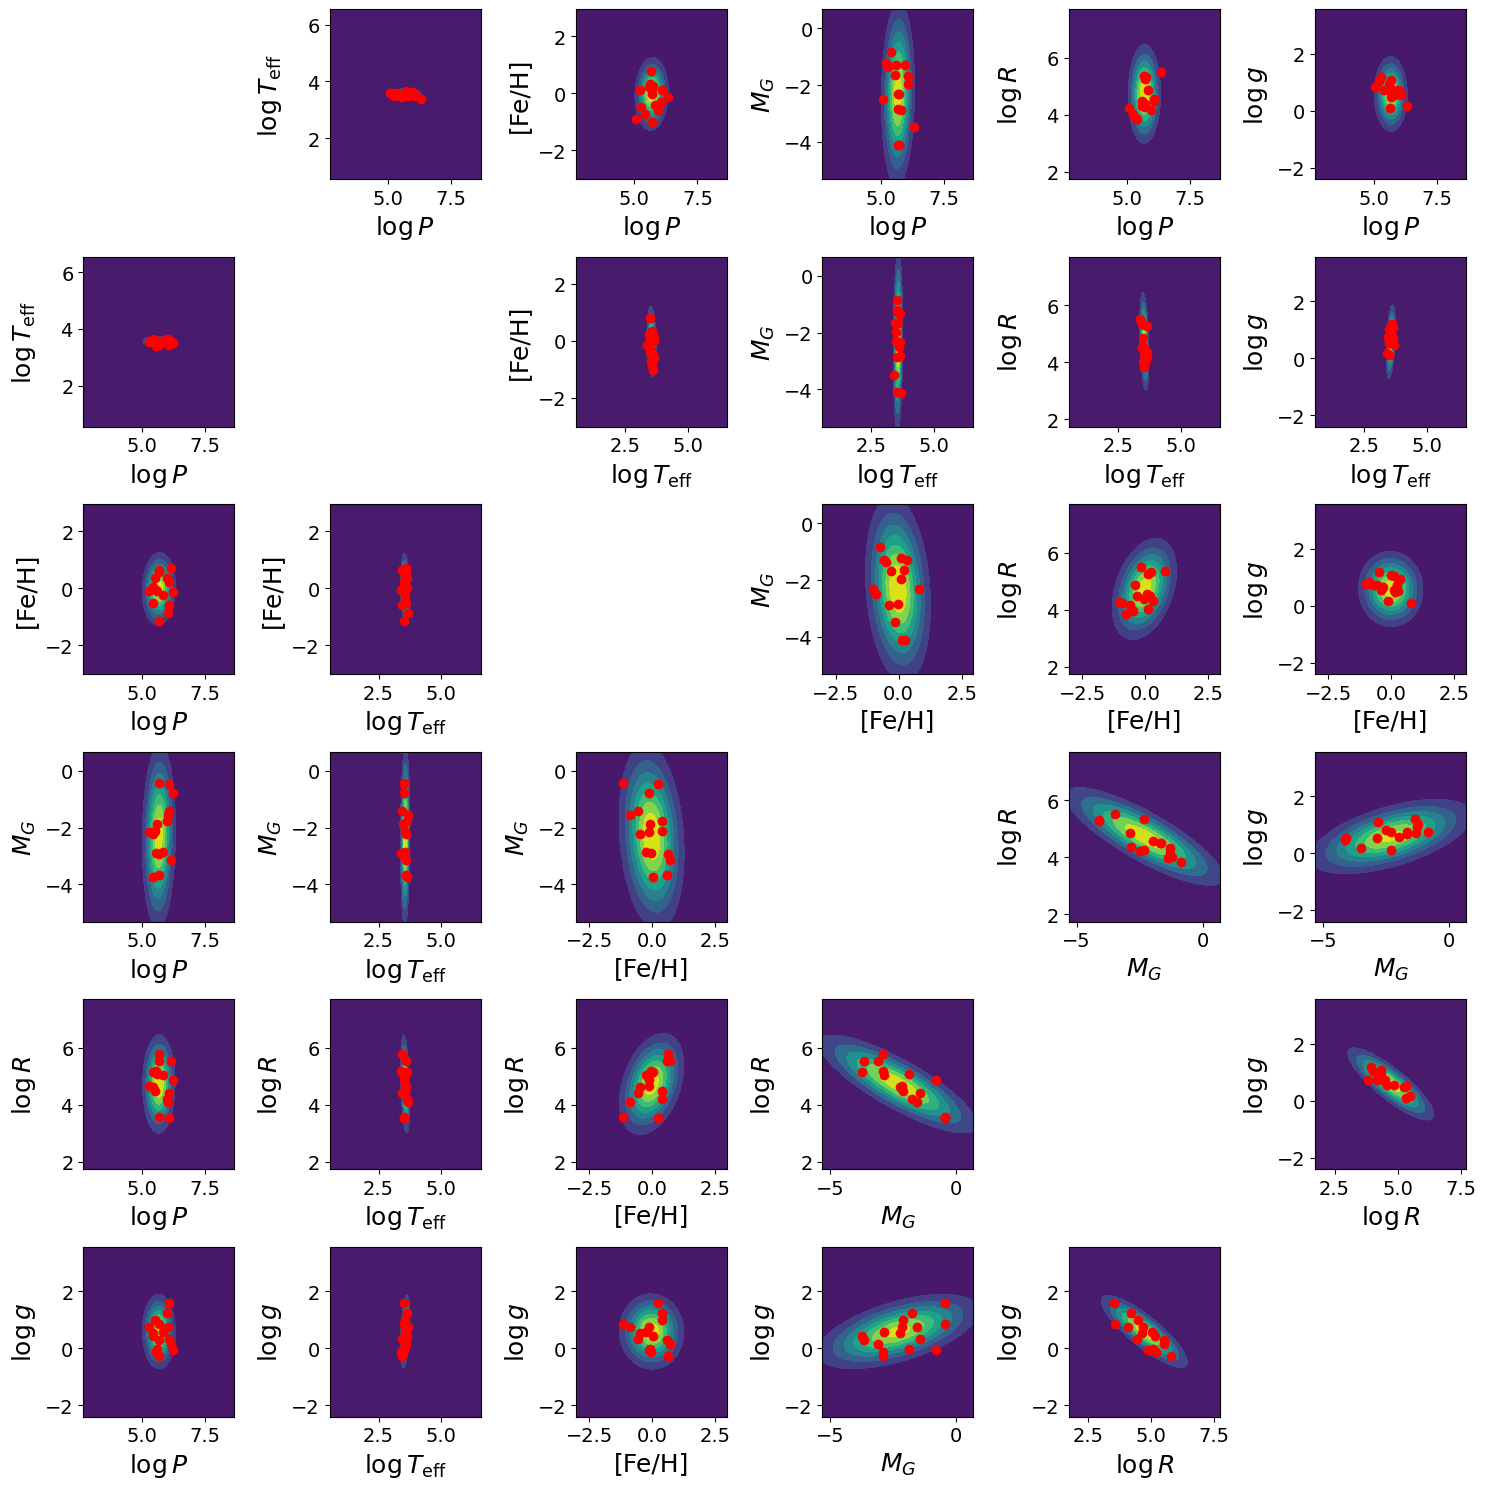

##################################################
star_class:  ECL
Initialization
sampler creation
Synthetic batcher creation
model loading,  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_ECL_priors_True_PP_6.pkl
Trying samples
16
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_ECL_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([1.8925, 8.5841, 0.    , 1.35  , 0.2283, 3.8333]),
                        n_components=3, random_state=42)
[0.4009 0.2485 0.3507]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([1.8925, 8.5841, 0.    , 1.35  , 0.2283, 3.8333]),
                        n_components=3, random_state=42)
[[ 0.8567  3.8443 -0.5722  2.3848  0.7385  3.9146]
 [ 0.9866  4.259  -0.5656 -0.1198  0.7346  4.4395]
 [ 0.093   3.7192 -1.3951  5.5196 -0.1371  4.4348]]
mode:  two_steps

Resampled Samples:
[[ 1.1

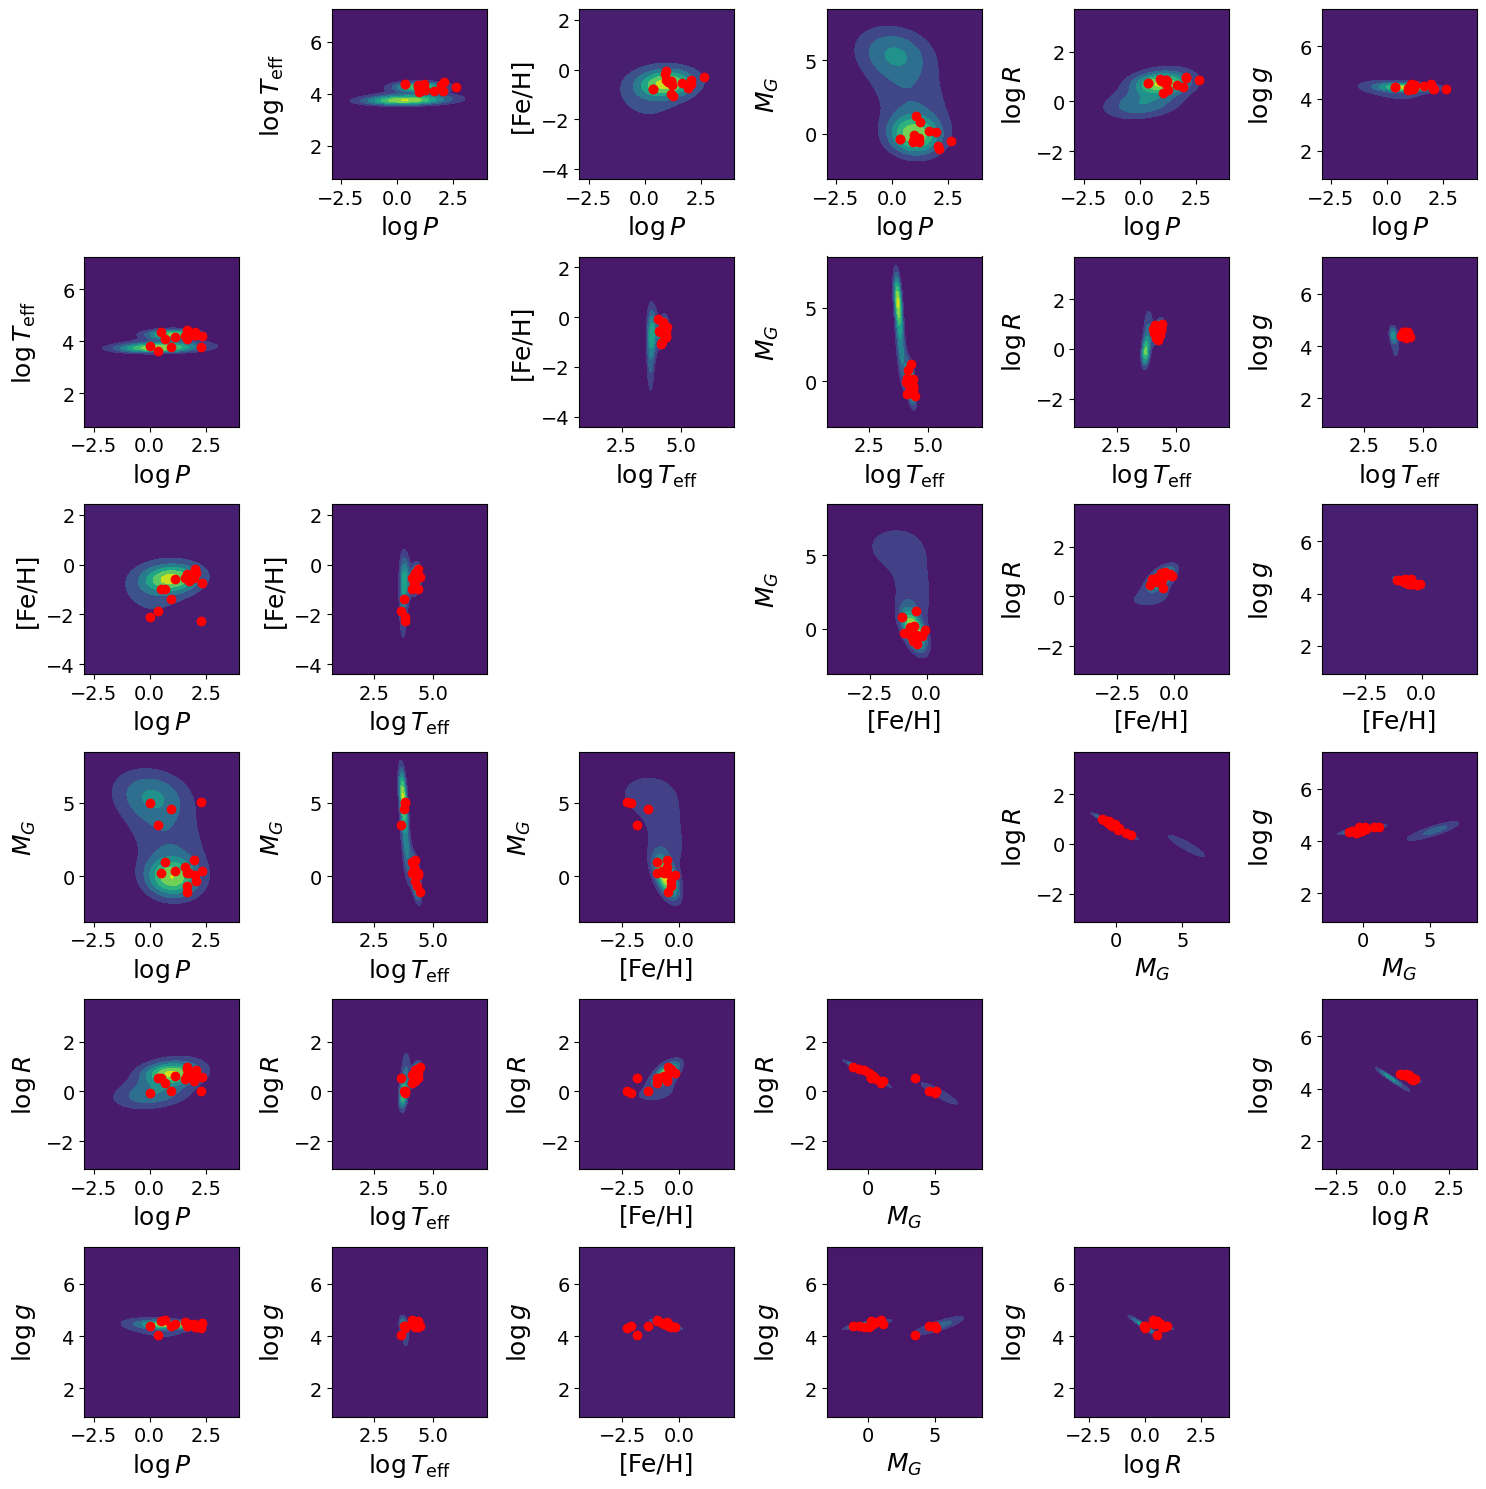

In [9]:
b = 1

for star_class in priors['StarTypes'].keys(): 
    
    if star_class in ['RRLYR', 'CEP', 'LPV', 'DSCT', 'ECL']:
        print('#'*50)
        print('star_class: ', star_class)
    
        components = len(priors['StarTypes'][star_class].keys())-3

    
        print('Initialization')
        sampler = ModifiedGaussianSampler(b=b, components=components, features=PP)

        print('sampler creation')

        batcher = SyntheticDataBatcher(pp = PP, vae_model=vae_model, n_samples=synthetic_samples_by_class, 
                                            seq_length = seq_length, prior=True)

        print('Synthetic batcher creation')

        model_name = batcher.construct_model_name(star_class, PATH_MODELS)

        print('model loading, ', model_name)

        samples, error = batcher.attempt_sample_load(model_name, sampler, n_samples=n_samples)
        
        
        print('Initialization')
        sampler = ModifiedGaussianSampler(b=b*0.5, components=components, features=PP)

        print('sampler creation')

        batcher = SyntheticDataBatcher(pp = PP, vae_model=vae_model, n_samples=synthetic_samples_by_class, 
                                            seq_length = seq_length, prior=True)

        print('Synthetic batcher creation')

        model_name = batcher.construct_model_name(star_class, PATH_MODELS)

        print('model loading, ', model_name)

        samples_b2, error = batcher.attempt_sample_load(model_name, sampler, n_samples=n_samples)

        sampler.plot_samples_densities_full(PP, samples, samples_b2, star_class)
        